In [ ]:
import requests
from bs4 import BeautifulSoup
import xarray as xr
import fsspec
import pandas as pd
import numpy as np
import os

# -----------------------
# Config
# -----------------------
BASE_URL = "https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/"
YEARS = range(2022, 2026)
MONTHS = [f"{m:02d}" for m in range(1, 13)]
OUT_DIR = "argo_2022_2025_parquet"
os.makedirs(OUT_DIR, exist_ok=True)

# -----------------------
# Function: process 1 file
# -----------------------
def process_argo_file(file_url: str) -> pd.DataFrame:
    """Download, flatten, and clean one Argo .nc file into a DataFrame"""
    with fsspec.open(file_url) as f:
        ds = xr.open_dataset(f, engine="scipy")

    # Infer dims (N_PROF, N_LEVELS)
    prof_dim = next((d for d in ds.dims if "N_PROF" in d), None)
    level_dim = next((d for d in ds.dims if "N_LEVEL" in d or "N_LEVELS" in d), None)

    # Flatten into DataFrame
    if prof_dim and level_dim:
        df = ds.stack(obs=[prof_dim, level_dim]).to_dataframe().reset_index()
    elif prof_dim:
        df = ds.stack(obs=[prof_dim]).to_dataframe().reset_index()
    else:
        df = ds.to_dataframe().reset_index()

    # Basic cleaning
    df.dropna(axis=1, how="all", inplace=True)  # drop fully empty columns
    thresh = int(0.1 * len(df))                 # drop cols >90% NaN
    df.dropna(axis=1, thresh=thresh, inplace=True)

    # Fill numeric NaNs with mean
    for col in df.select_dtypes(include=[np.number]).columns:
        if df[col].isna().any():
            df[col].fillna(df[col].mean(), inplace=True)

    df["source_file"] = file_url
    return df

# -----------------------
# Main loop
# -----------------------
for year in YEARS:
    print(f"\n📂 Processing year: {year}")
    for month in MONTHS:
        dir_url = f"{BASE_URL}{year}/{month}/"

        # Fetch directory listing
        try:
            resp = requests.get(dir_url, timeout=10)
            if resp.status_code != 200:
                continue
        except:
            continue

        soup = BeautifulSoup(resp.text, "html.parser")
        files = [a['href'] for a in soup.find_all('a') if a['href'].endswith(".nc")]
        if not files:
            continue

        month_data = []
        for file in files:   # ✅ take all files, not just one
            file_url = dir_url + file
            print(f"  🔹 Reading: {file_url}")
            try:
                df = process_argo_file(file_url)
                month_data.append(df)
            except Exception as e:
                print(f"    ⚠ Skipped {file}: {e}")

        # Save monthly parquet
        if month_data:
            final_df = pd.concat(month_data, ignore_index=True)
            out_file = f"{OUT_DIR}/{year}_{month}_ALL_PARAMS.parquet"
            final_df.to_parquet(out_file, index=False)
            print(f"✅ Saved Parquet: {out_file} | Shape: {final_df.shape}")

print("\n🎉 Processing complete! One Parquet per month with all detected parameters.")



📂 Processing year: 2022
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220101_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220101_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220102_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220102_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220103_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220103_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220104_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220104_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220105_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220105_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220106_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220106_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220107_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220107_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220108_prof.nc
    ⚠ Skipped 20220108_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220109_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220109_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220110_prof.nc
    ⚠ Skipped 20220110_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220111_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220111_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220112_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220112_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220113_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220113_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220114_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220114_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220115_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220115_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220116_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220116_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220117_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220117_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220118_prof.nc
    ⚠ Skipped 20220118_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220119_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220119_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220120_prof.nc
    ⚠ Skipped 20220120_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220121_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220121_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220122_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220122_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220123_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220123_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220124_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220124_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220125_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220125_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220126_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220126_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220127_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220127_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220128_prof.nc
    ⚠ Skipped 20220128_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220129_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220129_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220130_prof.nc
    ⚠ Skipped 20220130_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220131_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220131_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/02/20220201_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220201_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/02/20220202_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220202_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/02/20220203_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220203_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/02/20220204_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220204_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/02/20220205_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220205_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/02/20220206_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220206_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/02/20220207_prof.nc
    ⚠ Skipped 20220207_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/02/20220208_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220208_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/02/20220209_prof.nc
    ⚠ Skipped 20220209_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/02/20220210_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220210_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/02/20220211_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220211_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/02/20220212_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220212_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/02/20220213_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220213_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/02/20220214_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220214_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/02/20220215_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220215_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/02/20220216_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220216_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/02/20220217_prof.nc
    ⚠ Skipped 20220217_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/02/20220218_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220218_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/02/20220219_prof.nc
    ⚠ Skipped 20220219_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/02/20220220_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220220_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/02/20220221_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220221_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/02/20220222_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220222_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/02/20220223_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220223_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/02/20220224_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220224_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/02/20220225_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220225_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/02/20220226_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220226_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/02/20220227_prof.nc
    ⚠ Skipped 20220227_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/02/20220228_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220228_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/03/20220301_prof.nc
    ⚠ Skipped 20220301_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/03/20220302_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220302_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/03/20220303_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220303_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/03/20220304_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220304_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/03/20220305_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220305_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/03/20220306_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220306_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/03/20220307_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220307_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/03/20220308_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220308_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/03/20220309_prof.nc
    ⚠ Skipped 20220309_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/03/20220310_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220310_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/03/20220311_prof.nc
    ⚠ Skipped 20220311_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/03/20220312_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220312_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/03/20220313_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220313_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/03/20220314_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220314_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/03/20220315_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220315_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/03/20220316_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220316_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/03/20220317_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220317_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/03/20220318_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220318_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/03/20220319_prof.nc
    ⚠ Skipped 20220319_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/03/20220320_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220320_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/03/20220321_prof.nc
    ⚠ Skipped 20220321_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/03/20220322_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220322_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/03/20220323_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220323_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/03/20220324_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220324_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/03/20220325_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220325_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/03/20220326_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220326_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/03/20220327_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220327_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/03/20220328_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220328_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/03/20220329_prof.nc


/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-3758854293.py:24: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
T

    ⚠ Skipped 20220329_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
  🔹 Reading: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/03/20220330_prof.nc


KeyboardInterrupt: 

In [ ]:
import requests
from bs4 import BeautifulSoup
import xarray as xr
import fsspec
import pandas as pd
import numpy as np
import os
from concurrent.futures import ThreadPoolExecutor, as_completed

# -----------------------
# Config
# -----------------------
BASE_URL = "https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/"
YEARS = range(2022, 2026)
MONTHS = [f"{m:02d}" for m in range(1, 13)]
OUT_DIR = "argo_2022_2025_parquet"
os.makedirs(OUT_DIR, exist_ok=True)

# -----------------------
# Function: process 1 file
# -----------------------
def process_argo_file(file_url: str) -> pd.DataFrame:
    """Download, flatten, and clean one Argo .nc file into a DataFrame"""
    with fsspec.open(file_url) as f:
        ds = xr.open_dataset(f, engine="scipy")

    # Infer dims (N_PROF, N_LEVELS)
    prof_dim = next((d for d in ds.dims if "N_PROF" in d), None)
    level_dim = next((d for d in ds.dims if "N_LEVEL" in d or "N_LEVELS" in d), None)

    # Flatten into DataFrame
    if prof_dim and level_dim:
        df = ds.stack(obs=[prof_dim, level_dim]).to_dataframe().reset_index()
    elif prof_dim:
        df = ds.stack(obs=[prof_dim]).to_dataframe().reset_index()
    else:
        df = ds.to_dataframe().reset_index()

    # Basic cleaning
    df.dropna(axis=1, how="all", inplace=True)  # drop fully empty columns
    thresh = int(0.1 * len(df))                 # drop cols >90% NaN
    df.dropna(axis=1, thresh=thresh, inplace=True)

    # Fill numeric NaNs with mean
    for col in df.select_dtypes(include=[np.number]).columns:
        if df[col].isna().any():
            df[col].fillna(df[col].mean(), inplace=True)

    df["source_file"] = file_url
    return df

# -----------------------
# Main loop (parallelized)
# -----------------------
for year in YEARS:
    print(f"\n📂 Processing year: {year}")
    for month in MONTHS:
        dir_url = f"{BASE_URL}{year}/{month}/"

        # Fetch directory listing
        try:
            resp = requests.get(dir_url, timeout=10)
            if resp.status_code != 200:
                continue
        except:
            continue

        soup = BeautifulSoup(resp.text, "html.parser")
        files = [a['href'] for a in soup.find_all('a') if a['href'].endswith(".nc")]
        if not files:
            continue

        month_data = []
        # 🔹 Process files in parallel
        with ThreadPoolExecutor(max_workers=8) as executor:  # adjust workers depending on Colab runtime
            future_to_file = {executor.submit(process_argo_file, dir_url + file): file for file in files}

            for future in as_completed(future_to_file):
                file = future_to_file[future]
                try:
                    df = future.result()
                    month_data.append(df)
                    print(f"  ✅ Done: {file}")
                except Exception as e:
                    print(f"    ⚠ Skipped {file}: {e}")

        # Save monthly parquet
        if month_data:
            final_df = pd.concat(month_data, ignore_index=True)
            out_file = f"{OUT_DIR}/{year}_{month}_ALL_PARAMS.parquet"
            final_df.to_parquet(out_file, index=False)
            print(f"✅ Saved Parquet: {out_file} | Shape: {final_df.shape}")

print("\n🎉 Processing complete! One Parquet per month with all detected parameters.")



📂 Processing year: 2022


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220103_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220108_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220102_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220106_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220104_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220105_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220110_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220109_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/usr/local/lib/python3.12/dist-packages/xarray/coding/times.py:650: RuntimeWarning: invalid value encountered in cast
  flat_num = flat_num.astype(np.int64)


    ⚠ Skipped 20220112_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220113_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220114_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220115_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220116_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220118_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220120_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220119_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220122_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220123_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220124_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220126_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220125_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220128_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220129_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220130_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220111_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220101_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220107_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220121_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220117_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220131_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220127_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220202_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220201_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue 

    ⚠ Skipped 20220205_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220207_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220209_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220204_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220208_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220203_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220206_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220210_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220212_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220211_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220213_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220214_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220215_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220219_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220218_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220217_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220220_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220221_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220222_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220225_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220227_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220224_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220223_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220228_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220216_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220226_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220301_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220309_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220302_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220307_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220304_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220303_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220305_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220306_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220311_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220310_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220312_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220317_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220313_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220314_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220316_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220315_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220319_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220321_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220320_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220324_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220322_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220323_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220325_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220326_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220327_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220308_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220328_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220318_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220329_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220330_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220331_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220407_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220406_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220403_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220405_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220412_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220413_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220404_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220414_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220415_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220401_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220402_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220418_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220419_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220420_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220422_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220423_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220424_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220425_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220426_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220410_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220428_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220429_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220430_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220411_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220417_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220416_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220409_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220421_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220427_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220408_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220501_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220502_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220503_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220504_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220506_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220505_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220508_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220509_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220510_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220515_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220513_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220512_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220511_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220514_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220516_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220518_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220520_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220519_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220522_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220523_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220524_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220526_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220525_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220528_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220531_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220530_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220529_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220521_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220507_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220517_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220527_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220601_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220609_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220608_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220604_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220605_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220603_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220602_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220607_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220610_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220611_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220612_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220615_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220613_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220614_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220618_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220619_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220621_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220622_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220620_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220623_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220625_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220624_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220628_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220627_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220629_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220630_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220617_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220606_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220616_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220626_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220701_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220703_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220702_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220705_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220704_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220708_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220709_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220707_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220711_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220710_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220712_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220713_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220714_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220715_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220718_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220719_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220717_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220723_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220721_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220722_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220724_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220725_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220727_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220728_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220729_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220731_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220720_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220716_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220730_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220706_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220726_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220801_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220803_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220802_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220804_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220808_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220806_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220807_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220809_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220812_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220811_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220813_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220814_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220810_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220817_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220818_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220820_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220821_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220822_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220823_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220824_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

    ⚠ Skipped 20220828_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220827_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220826_prof.nc: cannot reshape array of size 0 into shape (0,newaxis)


/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds = xr.open_dataset(f, engine="scipy")
/tmp/ipython-input-504543416.py:25: FutureWarning: In a future version, xarray will not decode the variable 'MTIME_ADJUSTED' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To 

KeyboardInterrupt: 

In [ ]:
import requests
from bs4 import BeautifulSoup
import xarray as xr
import fsspec
import pandas as pd
import numpy as np
import os
import traceback
from concurrent.futures import ThreadPoolExecutor, as_completed

# -----------------------
# Config
# -----------------------
BASE_URL = "https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/"
YEARS = range(2022, 2026)
MONTHS = [f"{m:02d}" for m in range(1, 13)]
OUT_DIR = "argo_2022_2025_parquet"
os.makedirs(OUT_DIR, exist_ok=True)

# Speed / concurrency
USE_PARALLEL = True        # set False to process sequentially (exact original behaviour)
MAX_WORKERS = 6            # threads for downloading/processing (adjust to suit environment)

# -----------------------
# Helper: process 1 file
# -----------------------
def process_argo_file(file_url: str) -> pd.DataFrame:
    """
    Download, flatten, and clean one Argo .nc file into a DataFrame.
    Preserves all variables found; adds 'source_file'.
    """
    with fsspec.open(file_url) as f:
        # Avoid MTIME timedelta decode warnings by setting decode_timedelta=False
        ds = xr.open_dataset(f, engine="scipy", decode_timedelta=False)

    # Infer dims: try to find N_PROF and N_LEVEL(S)
    prof_dim = next((d for d in ds.dims if "N_PROF" in d or d.upper().startswith("N_PROF")), None)
    level_dim = next((d for d in ds.dims if "N_LEVEL" in d or "N_LEVELS" in d or d.upper().startswith("N_LEVEL")), None)

    # Flatten into DataFrame safely
    if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
        stacked = ds.stack(obs=(prof_dim, level_dim))
        df = stacked.to_dataframe().reset_index()
    elif prof_dim:
        stacked = ds.stack(obs=(prof_dim,))
        df = stacked.to_dataframe().reset_index()
    else:
        df = ds.to_dataframe().reset_index()

    # Basic cleaning (preserve behavior)
    df.dropna(axis=1, how="all", inplace=True)  # drop fully empty columns
    thresh = int(0.1 * len(df))                 # drop cols with >90% NaN
    if thresh > 0:
        df.dropna(axis=1, thresh=thresh, inplace=True)

    # Fill numeric NaNs with mean (same behavior as before)
    for col in df.select_dtypes(include=[np.number]).columns:
        if df[col].isna().any():
            # if column all NaN, mean() gives nan -> leave as-is
            m = df[col].mean()
            if not np.isnan(m):
                df[col].fillna(m, inplace=True)

    df["source_file"] = os.path.basename(file_url)
    return df

# -----------------------
# Helper: summarization
# -----------------------
def summarize_month(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create a compact summary DataFrame for the month:
    - overall mean TEMP/PSAL (if available)
    - stats by depth bins (surface 0-10m, mid 10-200m, deep >200m) using PRES or PRES_ADJUSTED
    - top source files by observation counts
    Returns a tidy DataFrame for saving; also printed diagnostics.
    """
    # copy to avoid modifying original
    s = df.copy()

    # derive DEPTH (use PRES_ADJUSTED then PRES)
    depth_col = None
    if "PRES_ADJUSTED" in s.columns:
        depth_col = "PRES_ADJUSTED"
    elif "PRES" in s.columns:
        depth_col = "PRES"

    # convert to numeric if possible
    if depth_col is not None:
        s[depth_col] = pd.to_numeric(s[depth_col], errors="coerce")

    # simple overall metrics
    metrics = []
    overall = {"metric": "overall", "n_obs": len(s)}
    if "TEMP" in s.columns:
        overall["temp_mean"] = float(s["TEMP"].mean()) if s["TEMP"].notna().any() else np.nan
        overall["temp_std"] = float(s["TEMP"].std()) if s["TEMP"].notna().any() else np.nan
    if "PSAL" in s.columns:
        overall["psal_mean"] = float(s["PSAL"].mean()) if s["PSAL"].notna().any() else np.nan
        overall["psal_std"] = float(s["PSAL"].std()) if s["PSAL"].notna().any() else np.nan
    metrics.append(overall)

    # depth bins
    if depth_col is not None:
        bins = [-1e9, 10, 200, 1e9]
        labels = ["surface_0_10m", "mid_10_200m", "deep_200m_plus"]
        s["depth_bin"] = pd.cut(s[depth_col], bins=bins, labels=labels)
        depth_stats = []
        for lbl in labels:
            sub = s[s["depth_bin"] == lbl]
            rec = {"metric": f"depth_bin::{lbl}", "n_obs": int(len(sub))}
            if "TEMP" in sub.columns and len(sub) > 0 and sub["TEMP"].notna().any():
                rec["temp_mean"] = float(sub["TEMP"].mean())
                rec["temp_std"] = float(sub["TEMP"].std())
            else:
                rec["temp_mean"], rec["temp_std"] = np.nan, np.nan
            if "PSAL" in sub.columns and len(sub) > 0 and sub["PSAL"].notna().any():
                rec["psal_mean"] = float(sub["PSAL"].mean())
                rec["psal_std"] = float(sub["PSAL"].std())
            else:
                rec["psal_mean"], rec["psal_std"] = np.nan, np.nan
            depth_stats.append(rec)
        metrics.extend(depth_stats)

    # top source files by count (helpful to see contributing floats)
    top_sources = (
        s["source_file"].value_counts().reset_index().rename(columns={"index": "source_file", "source_file": "n_obs"})
    )
    top10 = top_sources.head(10)
    # flatten top10 into metrics as separate rows
    for _, row in top10.iterrows():
        metrics.append({"metric": f"top_source::{row['source_file']}", "n_obs": int(row["n_obs"])})

    # turn into DataFrame
    summary_df = pd.DataFrame(metrics)
    # include some columns from the original if present (mean lat/lon for the month)
    if "LATITUDE" in s.columns:
        try:
            summary_df["lat_mean"] = float(s["LATITUDE"].mean())
        except Exception:
            summary_df["lat_mean"] = np.nan
    if "LONGITUDE" in s.columns:
        try:
            summary_df["lon_mean"] = float(s["LONGITUDE"].mean())
        except Exception:
            summary_df["lon_mean"] = np.nan

    return summary_df

# -----------------------
# Main loop (keeps all functionality)
# -----------------------
for year in YEARS:
    print(f"\n📂 Processing year: {year}")
    for month in MONTHS:
        dir_url = f"{BASE_URL}{year}/{month}/"

        # Fetch directory listing
        try:
            resp = requests.get(dir_url, timeout=10)
            if resp.status_code != 200:
                print(f"  (no listing or status {resp.status_code}): {dir_url}")
                continue
        except Exception as e:
            print(f"  (request error for {dir_url}): {e}")
            continue

        soup = BeautifulSoup(resp.text, "html.parser")
        files = [a['href'] for a in soup.find_all('a') if a.get('href', "").endswith(".nc")]
        if not files:
            # no .nc files for that month
            continue

        month_data = []

        # Option A: parallel
        if USE_PARALLEL:
            print(f"  ⚡ Processing {len(files)} files in parallel (max_workers={MAX_WORKERS})")
            with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
                future_to_file = {executor.submit(process_argo_file, dir_url + file): file for file in files}
                for future in as_completed(future_to_file):
                    file = future_to_file[future]
                    try:
                        df = future.result()
                        month_data.append(df)
                        print(f"    ✅ Done: {file} | rows: {len(df)}")
                    except Exception:
                        print(f"    ⚠ Skipped {file} due to error:")
                        traceback.print_exc()
        else:
            # Option B: sequential (original behavior)
            for file in files:
                file_url = dir_url + file
                print(f"  🔹 Reading: {file_url}")
                try:
                    df = process_argo_file(file_url)
                    month_data.append(df)
                    print(f"    ✅ Done: {file} | rows: {len(df)}")
                except Exception:
                    print(f"    ⚠ Skipped {file} due to error:")
                    traceback.print_exc()

        # Save monthly parquet (raw merged)
        if month_data:
            final_df = pd.concat(month_data, ignore_index=True)
            out_file = f"{OUT_DIR}/{year}_{month}_ALL_PARAMS.parquet"
            final_df.to_parquet(out_file, index=False)
            print(f"  ✅ Saved Parquet: {out_file} | Shape: {final_df.shape}")

            # --- Summarization step (lightweight) ---
            try:
                summary_df = summarize_month(final_df)
                out_summary = f"{OUT_DIR}/{year}_{month}_SUMMARY.parquet"
                summary_df.to_parquet(out_summary, index=False)
                print(f"  🔎 Saved SUMMARY: {out_summary} | rows: {len(summary_df)}")
            except Exception:
                print("  ⚠ Failed to create/save summary:")
                traceback.print_exc()

print("\n🎉 Processing complete! One Parquet (ALL_PARAMS) + one SUMMARY per month saved when data exists.")



📂 Processing year: 2022
  ⚡ Processing 31 files in parallel (max_workers=6)


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims

    ⚠ Skipped 20220103_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220102_prof.nc due to error:
    ⚠ Skipped 20220105_prof.nc due to error:
    ⚠ Skipped 20220106_prof.nc due to error:
    ⚠ Skipped 20220104_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims

    ⚠ Skipped 20220110_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220108_prof.nc due to error:
    ⚠ Skipped 20220109_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220112_prof.nc due to error:
    ⚠ Skipped 20220113_prof.nc due to error:
    ⚠ Skipped 20220114_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220115_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220116_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220118_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220120_prof.nc due to error:
    ⚠ Skipped 20220119_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220122_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220123_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


    ⚠ Skipped 20220124_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220125_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220126_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


    ⚠ Skipped 20220101_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220128_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


    ⚠ Skipped 20220129_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220130_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220111_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220107_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220117_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220121_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220127_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220131_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

  ⚡ Processing 28 files in parallel (max_workers=6)


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.

    ⚠ Skipped 20220201_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.

    ⚠ Skipped 20220207_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.

    ⚠ Skipped 20220202_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims

    ⚠ Skipped 20220205_prof.nc due to error:
    ⚠ Skipped 20220204_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220206_prof.nc due to error:
    ⚠ Skipped 20220209_prof.nc due to error:
    ⚠ Skipped 20220208_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220210_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims

    ⚠ Skipped 20220211_prof.nc due to error:
    ⚠ Skipped 20220203_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.

    ⚠ Skipped 20220212_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.

    ⚠ Skipped 20220213_prof.nc due to error:
    ⚠ Skipped 20220214_prof.nc due to error:
    ⚠ Skipped 20220215_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220218_prof.nc due to error:
    ⚠ Skipped 20220219_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220220_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220221_prof.nc due to error:
    ⚠ Skipped 20220217_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220222_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220223_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220224_prof.nc due to error:
    ⚠ Skipped 20220225_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220227_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220228_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220216_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220226_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

  ⚡ Processing 31 files in parallel (max_workers=6)


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.

    ⚠ Skipped 20220301_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims

    ⚠ Skipped 20220302_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims

    ⚠ Skipped 20220303_prof.nc due to error:
    ⚠ Skipped 20220304_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.

    ⚠ Skipped 20220305_prof.nc due to error:
    ⚠ Skipped 20220306_prof.nc due to error:
    ⚠ Skipped 20220307_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220309_prof.nc due to error:
    ⚠ Skipped 20220310_prof.nc due to error:
    ⚠ Skipped 20220311_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220312_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220314_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220313_prof.nc due to error:
    ⚠ Skipped 20220316_prof.nc due to error:
    ⚠ Skipped 20220315_prof.nc due to error:
    ⚠ Skipped 20220317_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220320_prof.nc due to error:
    ⚠ Skipped 20220321_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220322_prof.nc due to error:
    ⚠ Skipped 20220319_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220324_prof.nc due to error:
    ⚠ Skipped 20220323_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220325_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220326_prof.nc due to error:
    ⚠ Skipped 20220327_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220308_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220318_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220328_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220329_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220331_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220330_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

  ⚡ Processing 30 files in parallel (max_workers=6)


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


    ⚠ Skipped 20220403_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220406_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220405_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220404_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220402_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220401_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220412_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.

    ⚠ Skipped 20220413_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


    ⚠ Skipped 20220414_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220415_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


    ⚠ Skipped 20220407_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220408_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220410_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220418_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220409_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220419_prof.nc due to error:
    ⚠ Skipped 20220420_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220423_prof.nc due to error:
    ⚠ Skipped 20220422_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220424_prof.nc due to error:
    ⚠ Skipped 20220425_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220426_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220428_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220429_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.

    ⚠ Skipped 20220430_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


    ⚠ Skipped 20220411_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220417_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220416_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220421_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220427_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

  ⚡ Processing 31 files in parallel (max_workers=6)


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims

    ⚠ Skipped 20220501_prof.nc due to error:
    ⚠ Skipped 20220503_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220502_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220504_prof.nc due to error:
    ⚠ Skipped 20220505_prof.nc due to error:
    ⚠ Skipped 20220506_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220508_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220509_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220510_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220512_prof.nc due to error:
    ⚠ Skipped 20220513_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220511_prof.nc due to error:
    ⚠ Skipped 20220514_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220515_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220516_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220518_prof.nc due to error:
    ⚠ Skipped 20220519_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.

    ⚠ Skipped 20220520_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220522_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims

    ⚠ Skipped 20220523_prof.nc due to error:
    ⚠ Skipped 20220524_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220525_prof.nc due to error:
    ⚠ Skipped 20220526_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220528_prof.nc due to error:
    ⚠ Skipped 20220529_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220530_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220531_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220521_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220507_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220527_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220517_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

  ⚡ Processing 30 files in parallel (max_workers=6)


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims

    ⚠ Skipped 20220601_prof.nc due to error:
    ⚠ Skipped 20220602_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220608_prof.nc due to error:
    ⚠ Skipped 20220607_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220604_prof.nc due to error:
    ⚠ Skipped 20220603_prof.nc due to error:
    ⚠ Skipped 20220605_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220610_prof.nc due to error:
    ⚠ Skipped 20220609_prof.nc due to error:
    ⚠ Skipped 20220613_prof.nc due to error:
    ⚠ Skipped 20220611_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220612_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims

    ⚠ Skipped 20220615_prof.nc due to error:
    ⚠ Skipped 20220614_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220618_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220619_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220620_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220621_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220622_prof.nc due to error:
    ⚠ Skipped 20220623_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220624_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.

    ⚠ Skipped 20220625_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


    ⚠ Skipped 20220627_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220629_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220628_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220630_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220617_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220606_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220616_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220626_prof.nc due to error:
  ⚡ Processing 31 files in parallel (max_workers=6)


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.

    ⚠ Skipped 20220701_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


    ⚠ Skipped 20220702_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220704_prof.nc due to error:
    ⚠ Skipped 20220705_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.

    ⚠ Skipped 20220707_prof.nc due to error:
    ⚠ Skipped 20220703_prof.nc due to error:
    ⚠ Skipped 20220708_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220709_prof.nc due to error:
    ⚠ Skipped 20220710_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220711_prof.nc due to error:
    ⚠ Skipped 20220713_prof.nc due to error:
    ⚠ Skipped 20220712_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220714_prof.nc due to error:
    ⚠ Skipped 20220715_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220718_prof.nc due to error:
    ⚠ Skipped 20220719_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.

    ⚠ Skipped 20220717_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220721_prof.nc due to error:
    ⚠ Skipped 20220722_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220723_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220724_prof.nc due to error:
    ⚠ Skipped 20220725_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220727_prof.nc due to error:
    ⚠ Skipped 20220728_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220729_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


    ⚠ Skipped 20220731_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220720_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220706_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220730_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220716_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220726_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

  ⚡ Processing 31 files in parallel (max_workers=6)


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


    ⚠ Skipped 20220801_prof.nc due to error:
    ⚠ Skipped 20220803_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220804_prof.nc due to error:
    ⚠ Skipped 20220802_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.

    ⚠ Skipped 20220806_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims

    ⚠ Skipped 20220808_prof.nc due to error:
    ⚠ Skipped 20220807_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220809_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims

    ⚠ Skipped 20220810_prof.nc due to error:
    ⚠ Skipped 20220811_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.

    ⚠ Skipped 20220812_prof.nc due to error:
    ⚠ Skipped 20220813_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220814_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220817_prof.nc due to error:
    ⚠ Skipped 20220818_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220820_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


    ⚠ Skipped 20220821_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220822_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.

    ⚠ Skipped 20220823_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.

    ⚠ Skipped 20220824_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


    ⚠ Skipped 20220826_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220827_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220828_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220816_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220830_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.

    ⚠ Skipped 20220831_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


    ⚠ Skipped 20220819_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220805_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220829_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220825_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220815_prof.nc due to error:
  ⚡ Processing 30 files in parallel (max_workers=6)


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.

    ⚠ Skipped 20220901_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims

    ⚠ Skipped 20220902_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims

    ⚠ Skipped 20220906_prof.nc due to error:
    ⚠ Skipped 20220903_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220907_prof.nc due to error:
    ⚠ Skipped 20220905_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.

    ⚠ Skipped 20220909_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims

    ⚠ Skipped 20220908_prof.nc due to error:
    ⚠ Skipped 20220910_prof.nc due to error:
    ⚠ Skipped 20220912_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220913_prof.nc due to error:
    ⚠ Skipped 20220916_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220917_prof.nc due to error:
    ⚠ Skipped 20220918_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220919_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220921_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220922_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220923_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220911_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.

    ⚠ Skipped 20220925_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.

    ⚠ Skipped 20220926_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.

    ⚠ Skipped 20220927_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.

    ⚠ Skipped 20220928_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


    ⚠ Skipped 20220920_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220929_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220930_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220915_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220904_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220914_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20220924_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

  ⚡ Processing 31 files in parallel (max_workers=6)


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


    ⚠ Skipped 20221001_prof.nc due to error:
    ⚠ Skipped 20221002_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221003_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.

    ⚠ Skipped 20221007_prof.nc due to error:
    ⚠ Skipped 20221006_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221005_prof.nc due to error:
    ⚠ Skipped 20221008_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221009_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221010_prof.nc due to error:
    ⚠ Skipped 20221012_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221013_prof.nc due to error:
    ⚠ Skipped 20221011_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


    ⚠ Skipped 20221004_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221014_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221017_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221016_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221015_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221018_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221020_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221019_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221021_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221023_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221027_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


    ⚠ Skipped 20221022_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221024_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221025_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221030_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221026_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221029_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221028_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221031_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

  ⚡ Processing 30 files in parallel (max_workers=6)


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.

    ⚠ Skipped 20221106_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


    ⚠ Skipped 20221103_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221107_prof.nc due to error:
    ⚠ Skipped 20221102_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221104_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221105_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221112_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


    ⚠ Skipped 20221101_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221109_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221110_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221108_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221111_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221113_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221114_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221115_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221116_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221122_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221117_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221120_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221118_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221119_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221121_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221124_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221123_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221126_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221127_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221129_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221128_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221130_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221125_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

  ⚡ Processing 31 files in parallel (max_workers=6)


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


    ⚠ Skipped 20221206_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221202_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221204_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221203_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221209_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


    ⚠ Skipped 20221205_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221201_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221210_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221212_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221208_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221211_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221213_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221207_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221219_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221214_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221220_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221216_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221215_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221217_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221218_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221226_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221221_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221222_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221229_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221230_prof.nc due to error:


/tmp/ipython-input-2176132070.py:41: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if prof_dim and level_dim and (ds[prof_dim].size > 0 and ds.dims.get(level_dim, 0) > 0):
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


    ⚠ Skipped 20221223_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

    ⚠ Skipped 20221224_prof.nc due to error:


Traceback (most recent call last):
  File "/tmp/ipython-input-2176132070.py", line 184, in <cell line: 0>
    df = future.result()
         ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 449, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/usr/lib/python3.12/concurrent/futures/thread.py", line 59, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2176132070.py", line 42, in process_argo_file
    stacked = ds.stack(obs=(prof_dim, level_dim))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/util/deprecation_helpers.py", line 144, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xarray/core/dataset.py", line 

In [ ]:
import requests
from bs4 import BeautifulSoup
import xarray as xr
import fsspec
import pandas as pd
import numpy as np
import os
import traceback
from concurrent.futures import ThreadPoolExecutor, as_completed

# -----------------------
# Config
# -----------------------
BASE_URL = "https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/"
YEARS = range(2022, 2026)
MONTHS = [f"{m:02d}" for m in range(1, 13)]
OUT_DIR = "argo_2022_2025_parquet"
os.makedirs(OUT_DIR, exist_ok=True)

# Speed / concurrency
USE_PARALLEL = True        # set False to process sequentially
MAX_WORKERS = 6            # threads for downloading/processing

# -----------------------
# Helper: process 1 file
# -----------------------
def process_argo_file(file_url: str) -> pd.DataFrame:
    try:
        with fsspec.open(file_url) as f:
            ds = xr.open_dataset(f, engine="scipy", decode_timedelta=False)

        # Identify dimensions
        prof_dim = next((d for d in ds.dims if "N_PROF" in d or d.upper().startswith("N_PROF")), None)
        level_dim = next((d for d in ds.dims if "N_LEVEL" in d or "N_LEVELS" in d or d.upper().startswith("N_LEVEL")), None)

        # ✅ Guard: skip if any dimension is declared but has zero size
        if (prof_dim and ds.sizes.get(prof_dim, 0) == 0) or (level_dim and ds.sizes.get(level_dim, 0) == 0):
            print(f"⚠ Skipped {file_url}: declared but empty (N_PROF/N_LEVEL = 0)")
            return None

        # Stack safely
        if prof_dim and level_dim:
            stacked = ds.stack(obs=(prof_dim, level_dim))
        elif prof_dim:
            stacked = ds.stack(obs=(prof_dim,))
        else:
            stacked = ds

        df = stacked.to_dataframe().reset_index()

        # Basic cleaning
        df.dropna(axis=1, how="all", inplace=True)
        thresh = int(0.1 * len(df))
        if thresh > 0:
            df.dropna(axis=1, thresh=thresh, inplace=True)

        for col in df.select_dtypes(include=[np.number]).columns:
            if df[col].isna().any():
                m = df[col].mean()
                if not np.isnan(m):
                    df[col].fillna(m, inplace=True)

        df["source_file"] = os.path.basename(file_url)
        return df

    except Exception as e:
        print(f"⚠ Skipped {file_url} due to error: {e}")
        return None

# -----------------------
# Helper: summarization
# -----------------------
def summarize_month(df: pd.DataFrame) -> pd.DataFrame:
    s = df.copy()

    depth_col = None
    if "PRES_ADJUSTED" in s.columns:
        depth_col = "PRES_ADJUSTED"
    elif "PRES" in s.columns:
        depth_col = "PRES"

    if depth_col is not None:
        s[depth_col] = pd.to_numeric(s[depth_col], errors="coerce")

    metrics = []
    overall = {"metric": "overall", "n_obs": len(s)}
    if "TEMP" in s.columns:
        overall["temp_mean"] = float(s["TEMP"].mean()) if s["TEMP"].notna().any() else np.nan
        overall["temp_std"] = float(s["TEMP"].std()) if s["TEMP"].notna().any() else np.nan
    if "PSAL" in s.columns:
        overall["psal_mean"] = float(s["PSAL"].mean()) if s["PSAL"].notna().any() else np.nan
        overall["psal_std"] = float(s["PSAL"].std()) if s["PSAL"].notna().any() else np.nan
    metrics.append(overall)

    if depth_col is not None:
        bins = [-1e9, 10, 200, 1e9]
        labels = ["surface_0_10m", "mid_10_200m", "deep_200m_plus"]
        s["depth_bin"] = pd.cut(s[depth_col], bins=bins, labels=labels)
        for lbl in labels:
            sub = s[s["depth_bin"] == lbl]
            rec = {"metric": f"depth_bin::{lbl}", "n_obs": int(len(sub))}
            if "TEMP" in sub.columns and len(sub) > 0 and sub["TEMP"].notna().any():
                rec["temp_mean"] = float(sub["TEMP"].mean())
                rec["temp_std"] = float(sub["TEMP"].std())
            else:
                rec["temp_mean"], rec["temp_std"] = np.nan, np.nan
            if "PSAL" in sub.columns and len(sub) > 0 and sub["PSAL"].notna().any():
                rec["psal_mean"] = float(sub["PSAL"].mean())
                rec["psal_std"] = float(sub["PSAL"].std())
            else:
                rec["psal_mean"], rec["psal_std"] = np.nan, np.nan
            metrics.append(rec)

    top_sources = (
        s["source_file"].value_counts().reset_index().rename(columns={"index": "source_file", "source_file": "n_obs"})
    )
    for _, row in top_sources.head(10).iterrows():
        metrics.append({"metric": f"top_source::{row['source_file']}", "n_obs": int(row["n_obs"])})

    summary_df = pd.DataFrame(metrics)
    if "LATITUDE" in s.columns:
        summary_df["lat_mean"] = float(s["LATITUDE"].mean())
    if "LONGITUDE" in s.columns:
        summary_df["lon_mean"] = float(s["LONGITUDE"].mean())

    return summary_df

# -----------------------
# Main loop
# -----------------------
for year in YEARS:
    print(f"\n📂 Processing year: {year}")
    for month in MONTHS:
        dir_url = f"{BASE_URL}{year}/{month}/"
        try:
            resp = requests.get(dir_url, timeout=10)
            if resp.status_code != 200:
                print(f"  (no listing or status {resp.status_code}): {dir_url}")
                continue
        except Exception as e:
            print(f"  (request error for {dir_url}): {e}")
            continue

        soup = BeautifulSoup(resp.text, "html.parser")
        files = [a['href'] for a in soup.find_all('a') if a.get('href', "").endswith(".nc")]
        if not files:
            continue

        month_data = []

        if USE_PARALLEL:
            print(f"  ⚡ Processing {len(files)} files in parallel (max_workers={MAX_WORKERS})")
            with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
                future_to_file = {executor.submit(process_argo_file, dir_url + file): file for file in files}
                for future in as_completed(future_to_file):
                    file = future_to_file[future]
                    try:
                        df = future.result()
                        if df is not None and not df.empty:
                            month_data.append(df)
                            print(f"    ✅ Done: {file} | rows: {len(df)}")
                        else:
                            print(f"    ⚠ Skipped {file}: empty result")
                    except Exception:
                        print(f"    ⚠ Skipped {file} due to error:")
                        traceback.print_exc()
        else:
            for file in files:
                file_url = dir_url + file
                print(f"  🔹 Reading: {file_url}")
                try:
                    df = process_argo_file(file_url)
                    if df is not None and not df.empty:
                        month_data.append(df)
                        print(f"    ✅ Done: {file} | rows: {len(df)}")
                    else:
                        print(f"    ⚠ Skipped {file}: empty result")
                except Exception:
                    print(f"    ⚠ Skipped {file} due to error:")
                    traceback.print_exc()

        # ✅ Updated block with your logic
        if month_data:
            final_df = pd.concat([df for df in month_data if df is not None], ignore_index=True)
            if not final_df.empty:
                out_file = f"{OUT_DIR}/{year}_{month}_ALL_PARAMS.parquet"
                final_df.to_parquet(out_file, index=False)
                print(f"  ✅ Saved Parquet: {out_file} | Shape: {final_df.shape}")

                try:
                    summary_df = summarize_month(final_df)
                    out_summary = f"{OUT_DIR}/{year}_{month}_SUMMARY.parquet"
                    summary_df.to_parquet(out_summary, index=False)
                    print(f"  🔎 Saved SUMMARY: {out_summary} | rows: {len(summary_df)})")
                except Exception:
                    print("  ⚠ Failed to create/save summary:")
                    traceback.print_exc()
            else:
                print(f"  ⚠ No usable data for {year}-{month}")
        else:
            print(f"  ⚠ All files empty for {year}-{month}")

print("\n🎉 Processing complete! One Parquet (ALL_PARAMS) + one SUMMARY per month saved when data exists.")



📂 Processing year: 2022
  ⚡ Processing 31 files in parallel (max_workers=6)
⚠ Skipped https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220103_prof.nc due to error: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220103_prof.nc
    ⚠ Skipped 20220103_prof.nc: empty result
⚠ Skipped https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220107_prof.nc due to error: https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220107_prof.nc
    ⚠ Skipped 20220107_prof.nc: empty result
⚠ Skipped https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220102_prof.nc due to error: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220102_prof.nc: empty result
⚠ Skipped https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220106_prof.nc due to error: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220106_prof.nc: empty result
⚠ Skipped https://usgodae.org/pub/outgoing/argo/geo/indian_

In [ ]:
import requests
from bs4 import BeautifulSoup
import xarray as xr
import fsspec
import pandas as pd
import numpy as np
import os
import traceback
from concurrent.futures import ThreadPoolExecutor, as_completed
import tempfile

# -----------------------
# Config
# -----------------------
BASE_URL = "https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/"
YEARS = range(2022, 2026)
MONTHS = [f"{m:02d}" for m in range(1, 13)]
OUT_DIR = "argo_2022_2025_parquet"
os.makedirs(OUT_DIR, exist_ok=True)

# Speed / concurrency
USE_PARALLEL = True        # set False to process sequentially
MAX_WORKERS = 6            # threads for downloading/processing

# -----------------------
# Helper: process 1 file
# -----------------------
def process_argo_file(file_url: str) -> pd.DataFrame:
    try:
        # --- download to temp file ---
        with tempfile.NamedTemporaryFile(suffix=".nc") as tmp:
            with requests.get(file_url, stream=True, timeout=60) as r:
                r.raise_for_status()
                for chunk in r.iter_content(chunk_size=1024*1024):
                    tmp.write(chunk)
            tmp.flush()

            # --- try opening dataset ---
            try:
                ds = xr.open_dataset(tmp.name, engine="netcdf4", decode_cf=False)
            except Exception:
                ds = xr.open_dataset(tmp.name, engine="scipy", decode_timedelta=False)

        # --- identify dimensions ---
        prof_dim = next((d for d in ds.dims if "N_PROF" in d or d.upper().startswith("N_PROF")), None)
        level_dim = next((d for d in ds.dims if "N_LEVEL" in d or "N_LEVELS" in d or d.upper().startswith("N_LEVEL")), None)

        if (prof_dim and ds.sizes.get(prof_dim, 0) == 0) or (level_dim and ds.sizes.get(level_dim, 0) == 0):
            print(f"⚠ Skipped {file_url}: declared but empty (N_PROF/N_LEVEL = 0)")
            return None

        # --- stack safely ---
        if prof_dim and level_dim:
            stacked = ds.stack(obs=(prof_dim, level_dim))
        elif prof_dim:
            stacked = ds.stack(obs=(prof_dim,))
        else:
            stacked = ds

        df = stacked.to_dataframe().reset_index()

        # --- cleaning ---
        df.dropna(axis=1, how="all", inplace=True)
        thresh = int(0.1 * len(df))
        if thresh > 0:
            df.dropna(axis=1, thresh=thresh, inplace=True)

        for col in df.select_dtypes(include=[np.number]).columns:
            if df[col].isna().any():
                m = df[col].mean()
                if not np.isnan(m):
                    df[col].fillna(m, inplace=True)

        df["source_file"] = os.path.basename(file_url)
        return df

    except Exception as e:
        print(f"⚠ Skipped {file_url} due to error: {e}")
        return None

# -----------------------
# Helper: summarization
# -----------------------
def summarize_month(df: pd.DataFrame) -> pd.DataFrame:
    s = df.copy()

    depth_col = None
    if "PRES_ADJUSTED" in s.columns:
        depth_col = "PRES_ADJUSTED"
    elif "PRES" in s.columns:
        depth_col = "PRES"

    if depth_col is not None:
        s[depth_col] = pd.to_numeric(s[depth_col], errors="coerce")

    metrics = []
    overall = {"metric": "overall", "n_obs": len(s)}
    if "TEMP" in s.columns:
        overall["temp_mean"] = float(s["TEMP"].mean()) if s["TEMP"].notna().any() else np.nan
        overall["temp_std"] = float(s["TEMP"].std()) if s["TEMP"].notna().any() else np.nan
    if "PSAL" in s.columns:
        overall["psal_mean"] = float(s["PSAL"].mean()) if s["PSAL"].notna().any() else np.nan
        overall["psal_std"] = float(s["PSAL"].std()) if s["PSAL"].notna().any() else np.nan
    metrics.append(overall)

    if depth_col is not None:
        bins = [-1e9, 10, 200, 1e9]
        labels = ["surface_0_10m", "mid_10_200m", "deep_200m_plus"]
        s["depth_bin"] = pd.cut(s[depth_col], bins=bins, labels=labels)
        for lbl in labels:
            sub = s[s["depth_bin"] == lbl]
            rec = {"metric": f"depth_bin::{lbl}", "n_obs": int(len(sub))}
            if "TEMP" in sub.columns and len(sub) > 0 and sub["TEMP"].notna().any():
                rec["temp_mean"] = float(sub["TEMP"].mean())
                rec["temp_std"] = float(sub["TEMP"].std())
            else:
                rec["temp_mean"], rec["temp_std"] = np.nan, np.nan
            if "PSAL" in sub.columns and len(sub) > 0 and sub["PSAL"].notna().any():
                rec["psal_mean"] = float(sub["PSAL"].mean())
                rec["psal_std"] = float(sub["PSAL"].std())
            else:
                rec["psal_mean"], rec["psal_std"] = np.nan, np.nan
            metrics.append(rec)

    top_sources = (
        s["source_file"].value_counts().reset_index().rename(columns={"index": "source_file", "source_file": "n_obs"})
    )
    for _, row in top_sources.head(10).iterrows():
        metrics.append({"metric": f"top_source::{row['source_file']}", "n_obs": int(row["n_obs"])})

    summary_df = pd.DataFrame(metrics)
    if "LATITUDE" in s.columns:
        summary_df["lat_mean"] = float(s["LATITUDE"].mean())
    if "LONGITUDE" in s.columns:
        summary_df["lon_mean"] = float(s["LONGITUDE"].mean())

    return summary_df

# -----------------------
# Main loop
# -----------------------
for year in YEARS:
    print(f"\n📂 Processing year: {year}")
    for month in MONTHS:
        dir_url = f"{BASE_URL}{year}/{month}/"
        try:
            resp = requests.get(dir_url, timeout=10)
            if resp.status_code != 200:
                print(f"  (no listing or status {resp.status_code}): {dir_url}")
                continue
        except Exception as e:
            print(f"  (request error for {dir_url}): {e}")
            continue

        soup = BeautifulSoup(resp.text, "html.parser")
        files = [a['href'] for a in soup.find_all('a') if a.get('href', "").endswith(".nc")]
        if not files:
            continue

        month_data = []

        if USE_PARALLEL:
            print(f"  ⚡ Processing {len(files)} files in parallel (max_workers={MAX_WORKERS})")
            with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
                future_to_file = {executor.submit(process_argo_file, dir_url + file): file for file in files}
                for future in as_completed(future_to_file):
                    file = future_to_file[future]
                    try:
                        df = future.result()
                        if df is not None and not df.empty:
                            month_data.append(df)
                            print(f"    ✅ Done: {file} | rows: {len(df)}")
                        else:
                            print(f"    ⚠ Skipped {file}: empty result")
                    except Exception:
                        print(f"    ⚠ Skipped {file} due to error:")
                        traceback.print_exc()
        else:
            for file in files:
                file_url = dir_url + file
                print(f"  🔹 Reading: {file_url}")
                try:
                    df = process_argo_file(file_url)
                    if df is not None and not df.empty:
                        month_data.append(df)
                        print(f"    ✅ Done: {file} | rows: {len(df)}")
                    else:
                        print(f"    ⚠ Skipped {file}: empty result")
                except Exception:
                    print(f"    ⚠ Skipped {file} due to error:")
                    traceback.print_exc()

        # --- monthly parquet saving ---
        if month_data:
            final_df = pd.concat([df for df in month_data if df is not None], ignore_index=True)
            if not final_df.empty:
                out_file = f"{OUT_DIR}/{year}_{month}_ALL_PARAMS.parquet"
                final_df.to_parquet(out_file, index=False)
                print(f"  ✅ Saved Parquet: {out_file} | Shape: {final_df.shape}")

                try:
                    summary_df = summarize_month(final_df)
                    out_summary = f"{OUT_DIR}/{year}_{month}_SUMMARY.parquet"
                    summary_df.to_parquet(out_summary, index=False)
                    print(f"  🔎 Saved SUMMARY: {out_summary} | rows: {len(summary_df)})")
                except Exception:
                    print("  ⚠ Failed to create/save summary:")
                    traceback.print_exc()
            else:
                print(f"  ⚠ No usable data for {year}-{month}")
        else:
            print(f"  ⚠ All files empty for {year}-{month}")

print("\n🎉 Processing complete! One Parquet (ALL_PARAMS) + one SUMMARY per month saved when data exists.")



📂 Processing year: 2022
  ⚡ Processing 31 files in parallel (max_workers=6)
⚠ Skipped https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220105_prof.nc due to error: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220105_prof.nc: empty result
⚠ Skipped https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220106_prof.nc due to error: cannot reshape array of size 0 into shape (0,newaxis)
⚠ Skipped https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220102_prof.nc due to error: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220102_prof.nc: empty result
    ⚠ Skipped 20220106_prof.nc: empty result
⚠ Skipped https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220101_prof.nc due to error: cannot reshape array of size 0 into shape (0,newaxis)
    ⚠ Skipped 20220101_prof.nc: empty result
⚠ Skipped https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/2022/01/20220107_prof.nc due to error: cannot 

KeyboardInterrupt: 

In [ ]:
import requests
from bs4 import BeautifulSoup
import xarray as xr
import pandas as pd
import numpy as np
import os
import tempfile
import traceback
from concurrent.futures import ThreadPoolExecutor, as_completed

# -----------------------
# Config
# -----------------------
BASE_URL = "https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/"
YEARS = range(2022, 2025)
MONTHS = [f"{m:02d}" for m in range(1, 13)]
OUT_DIR = "argo_2022_2025_parquet"
os.makedirs(OUT_DIR, exist_ok=True)

# Speed / concurrency
USE_PARALLEL = True        # set False to process sequentially
MAX_WORKERS = 6            # threads for downloading/processing

# -----------------------
# Helper: safe flattening of a dataset into a DataFrame
# -----------------------
def open_dataset_with_fallback(path_or_file) -> xr.Dataset:
    """
    Try netCDF4 first (best for modern files), then fallback to scipy.
    Accepts a local filename or a file-like object (but we pass filenames).
    """
    try:
        # prefer netCDF4, disable decode_cf to avoid some automatic conversions that may fail
        ds = xr.open_dataset(path_or_file, engine="netcdf4", decode_cf=False)
        return ds
    except Exception:
        # fallback to scipy (older netcdf3)
        ds = xr.open_dataset(path_or_file, engine="scipy", decode_timedelta=False)
        return ds

def flatten_ds_to_df(ds: xr.Dataset, source_file_name: str) -> pd.DataFrame:
    """
    Build a DataFrame WITHOUT using ds.stack, but by flattening variables manually.
    Handles variables with shapes:
      - (n_prof, n_level)
      - (n_prof,)
      - scalar
    Skips variables with incompatible shapes or zero size.
    """
    # coordinates typically present
    lat = None
    lon = None
    juld = None
    if "LATITUDE" in ds.variables:
        lat = np.asarray(ds["LATITUDE"].values)
    if "LONGITUDE" in ds.variables:
        lon = np.asarray(ds["LONGITUDE"].values)
    if "JULD" in ds.variables:
        try:
            juld = pd.to_datetime(ds["JULD"].values)
        except Exception:
            # ensure something usable
            juld = np.asarray(ds["JULD"].values)

    # infer profile/level dims sizes (safe)
    prof_dim = next((d for d in ds.dims if "N_PROF" in d or d.upper().startswith("N_PROF")), None)
    level_dim = next((d for d in ds.dims if "N_LEVEL" in d or "N_LEVELS" in d or d.upper().startswith("N_LEVEL")), None)

    n_prof = int(ds.sizes.get(prof_dim, 0)) if prof_dim else (len(lat) if lat is not None else 0)
    n_level = int(ds.sizes.get(level_dim, 1)) if level_dim else 1

    # If there are no profiles (n_prof == 0) consider dataset empty
    if n_prof == 0:
        raise ValueError("Dataset has zero profiles (n_prof == 0)")

    # total flattened length
    total_len = n_prof * n_level

    # base arrays: repeat coords per level
    # if lat/lon/juld are missing, attempt to find alternative variables or set NaNs
    if lat is None:
        lat_arr = np.full(total_len, np.nan)
    else:
        if lat.size != n_prof:
            # attempt to coerce - if a scalar, repeat
            if lat.size == 1:
                lat = np.repeat(lat, n_prof)
            else:
                raise ValueError(f"LATITUDE size ({lat.size}) doesn't match n_prof ({n_prof})")
        lat_arr = np.repeat(lat, n_level)

    if lon is None:
        lon_arr = np.full(total_len, np.nan)
    else:
        if lon.size != n_prof:
            if lon.size == 1:
                lon = np.repeat(lon, n_prof)
            else:
                raise ValueError(f"LONGITUDE size ({lon.size}) doesn't match n_prof ({n_prof})")
        lon_arr = np.repeat(lon, n_level)

    if juld is None:
        juld_arr = np.full(total_len, pd.NaT, dtype=object)
    else:
        if len(juld) != n_prof:
            if np.size(juld) == 1:
                juld = np.repeat(juld, n_prof)
            else:
                # coerce to string or leave as-is
                juld = np.array(juld, dtype=object)
        juld_arr = np.repeat(juld, n_level)

    base_df = pd.DataFrame({
        "LATITUDE": lat_arr,
        "LONGITUDE": lon_arr,
        "JULD": juld_arr
    })

    # Try PRES_ADJUSTED then PRES to produce DEPTH_M
    depth_col_vals = None
    if "PRES_ADJUSTED" in ds.variables:
        try:
            arr = np.asarray(ds["PRES_ADJUSTED"].values)
            if arr.size == 0:
                depth_col_vals = None
            elif arr.ndim == 2 and arr.shape == (n_prof, n_level):
                depth_col_vals = arr.flatten()
            elif arr.ndim == 1 and arr.shape[0] == n_prof:
                depth_col_vals = np.repeat(arr, n_level)
            elif arr.ndim == 0:
                depth_col_vals = np.repeat(arr.item(), total_len)
        except Exception:
            depth_col_vals = None

    if depth_col_vals is None and "PRES" in ds.variables:
        try:
            arr = np.asarray(ds["PRES"].values)
            if arr.size == 0:
                depth_col_vals = None
            elif arr.ndim == 2 and arr.shape == (n_prof, n_level):
                depth_col_vals = arr.flatten()
            elif arr.ndim == 1 and arr.shape[0] == n_prof:
                depth_col_vals = np.repeat(arr, n_level)
            elif arr.ndim == 0:
                depth_col_vals = np.repeat(arr.item(), total_len)
        except Exception:
            depth_col_vals = None

    base_df["DEPTH_M"] = depth_col_vals if depth_col_vals is not None else np.nan

    # Now iterate all variables and safely flatten relevant ones
    for var in ds.variables:
        if var in ["LATITUDE", "LONGITUDE", "JULD"]:
            continue  # already handled
        # Skip coordinate dims
        data = ds[var].values
        try:
            arr = np.asarray(data)
        except Exception:
            # skip unreadable var
            continue

        if arr.size == 0:
            # skip empty variables
            # print debug once per var
            # print(f"  (skip var {var} because it's empty)")
            continue

        # 2D var shaped (n_prof, n_level)
        if arr.ndim == 2 and arr.shape[0] == n_prof and arr.shape[1] == n_level:
            flat = arr.flatten()
            base_df[var] = flat
            continue

        # 1D var shaped (n_prof,)
        if arr.ndim == 1 and arr.shape[0] == n_prof:
            base_df[var] = np.repeat(arr, n_level)
            continue

        # scalar
        if arr.ndim == 0:
            base_df[var] = np.repeat(arr.item(), total_len)
            continue

        # other shapes: try to broadcast if possible
        # e.g., (n_level,) -> tile across n_prof
        if arr.ndim == 1 and arr.shape[0] == n_level:
            base_df[var] = np.tile(arr, n_prof)
            continue

        # if we get here shapes don't match the expected pattern; skip variable
        # print debug
        # print(f"  (skip var {var}: unexpected shape {arr.shape})")
        continue

    # Cleaning similar to your pipeline
    base_df.dropna(axis=1, how="all", inplace=True)
    thresh = int(0.1 * len(base_df))
    if thresh > 0:
        base_df.dropna(axis=1, thresh=thresh, inplace=True)

    # fill numeric NaNs with mean as before
    for col in base_df.select_dtypes(include=[np.number]).columns:
        if base_df[col].isna().any():
            m = base_df[col].mean()
            if not np.isnan(m):
                base_df[col].fillna(m, inplace=True)

    base_df["source_file"] = source_file_name
    return base_df

# -----------------------
# Worker: process 1 file (download + open + flatten)
# -----------------------
def process_argo_file(file_url: str) -> pd.DataFrame:
    """
    Download file to temp, open with netcdf4 (fallback to scipy),
    then flatten safely to DataFrame.
    """
    try:
        # Download to temp file
        with tempfile.NamedTemporaryFile(suffix=".nc") as tmp:
            with requests.get(file_url, stream=True, timeout=60) as r:
                r.raise_for_status()
                for chunk in r.iter_content(chunk_size=1024*1024):
                    tmp.write(chunk)
            tmp.flush()

            # Open dataset with fallback
            try:
                ds = xr.open_dataset(tmp.name, engine="netcdf4", decode_cf=False)
            except Exception:
                ds = xr.open_dataset(tmp.name, engine="scipy", decode_timedelta=False)

            # convert dataset into DataFrame safely
            source_name = os.path.basename(file_url)
            df = flatten_ds_to_df(ds, source_name)
            # close dataset to free resources
            ds.close()
            return df

    except Exception as e:
        # show a short, informative message
        print(f"⚠ Skipped {file_url} due to error: {e}")
        return None

# -----------------------
# Helper: summarization (unchanged logic)
# -----------------------
def summarize_month(df: pd.DataFrame) -> pd.DataFrame:
    s = df.copy()

    depth_col = None
    if "PRES_ADJUSTED" in s.columns:
        depth_col = "PRES_ADJUSTED"
    elif "PRES" in s.columns:
        depth_col = "PRES"
    elif "DEPTH_M" in s.columns:
        depth_col = "DEPTH_M"

    if depth_col is not None:
        s[depth_col] = pd.to_numeric(s[depth_col], errors="coerce")

    metrics = []
    overall = {"metric": "overall", "n_obs": len(s)}
    if "TEMP" in s.columns:
        overall["temp_mean"] = float(s["TEMP"].mean()) if s["TEMP"].notna().any() else np.nan
        overall["temp_std"] = float(s["TEMP"].std()) if s["TEMP"].notna().any() else np.nan
    if "PSAL" in s.columns:
        overall["psal_mean"] = float(s["PSAL"].mean()) if s["PSAL"].notna().any() else np.nan
        overall["psal_std"] = float(s["PSAL"].std()) if s["PSAL"].notna().any() else np.nan
    metrics.append(overall)

    if depth_col is not None:
        bins = [-1e9, 10, 200, 1e9]
        labels = ["surface_0_10m", "mid_10_200m", "deep_200m_plus"]
        s["depth_bin"] = pd.cut(s[depth_col], bins=bins, labels=labels)
        for lbl in labels:
            sub = s[s["depth_bin"] == lbl]
            rec = {"metric": f"depth_bin::{lbl}", "n_obs": int(len(sub))}
            if "TEMP" in sub.columns and len(sub) > 0 and sub["TEMP"].notna().any():
                rec["temp_mean"] = float(sub["TEMP"].mean())
                rec["temp_std"] = float(sub["TEMP"].std())
            else:
                rec["temp_mean"], rec["temp_std"] = np.nan, np.nan
            if "PSAL" in sub.columns and len(sub) > 0 and sub["PSAL"].notna().any():
                rec["psal_mean"] = float(sub["PSAL"].mean())
                rec["psal_std"] = float(sub["PSAL"].std())
            else:
                rec["psal_mean"], rec["psal_std"] = np.nan, np.nan
            metrics.append(rec)

    top_sources = (
        s["source_file"].value_counts().reset_index().rename(columns={"index": "source_file", "source_file": "n_obs"})
    )
    for _, row in top_sources.head(10).iterrows():
        metrics.append({"metric": f"top_source::{row['source_file']}", "n_obs": int(row["n_obs"])})

    summary_df = pd.DataFrame(metrics)
    if "LATITUDE" in s.columns:
        try:
            summary_df["lat_mean"] = float(s["LATITUDE"].mean())
        except Exception:
            summary_df["lat_mean"] = np.nan
    if "LONGITUDE" in s.columns:
        try:
            summary_df["lon_mean"] = float(s["LONGITUDE"].mean())
        except Exception:
            summary_df["lon_mean"] = np.nan

    return summary_df

# -----------------------
# Main loop
# -----------------------
for year in YEARS:
    print(f"\n📂 Processing year: {year}")
    for month in MONTHS:
        dir_url = f"{BASE_URL}{year}/{month}/"
        try:
            resp = requests.get(dir_url, timeout=10)
            if resp.status_code != 200:
                print(f"  (no listing or status {resp.status_code}): {dir_url}")
                continue
        except Exception as e:
            print(f"  (request error for {dir_url}): {e}")
            continue

        soup = BeautifulSoup(resp.text, "html.parser")
        files = [a.get('href') for a in soup.find_all('a') if a.get('href', "").endswith(".nc")]
        if not files:
            continue

        month_data = []

        if USE_PARALLEL:
            print(f"  ⚡ Processing {len(files)} files in parallel (max_workers={MAX_WORKERS})")
            with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
                future_to_file = {executor.submit(process_argo_file, dir_url + file): file for file in files}
                for future in as_completed(future_to_file):
                    file = future_to_file[future]
                    try:
                        df = future.result()
                        if df is not None and not df.empty:
                            month_data.append(df)
                            print(f"    ✅ Done: {file} | rows: {len(df)}")
                        else:
                            print(f"    ⚠ Skipped {file}: empty result")
                    except Exception:
                        print(f"    ⚠ Skipped {file} due to error:")
                        traceback.print_exc()
        else:
            for file in files:
                file_url = dir_url + file
                print(f"  🔹 Reading: {file_url}")
                try:
                    df = process_argo_file(file_url)
                    if df is not None and not df.empty:
                        month_data.append(df)
                        print(f"    ✅ Done: {file} | rows: {len(df)}")
                    else:
                        print(f"    ⚠ Skipped {file}: empty result")
                except Exception:
                    print(f"    ⚠ Skipped {file} due to error:")
                    traceback.print_exc()

        # ✅ safe saving block
        if month_data:
            final_df = pd.concat([df for df in month_data if df is not None], ignore_index=True)
            if not final_df.empty:
                out_file = f"{OUT_DIR}/{year}_{month}_ALL_PARAMS.parquet"
                final_df.to_parquet(out_file, index=False)
                print(f"  ✅ Saved Parquet: {out_file} | Shape: {final_df.shape}")

                try:
                    summary_df = summarize_month(final_df)
                    out_summary = f"{OUT_DIR}/{year}_{month}_SUMMARY.parquet"
                    summary_df.to_parquet(out_summary, index=False)
                    print(f"  🔎 Saved SUMMARY: {out_summary} | rows: {len(summary_df)})")
                except Exception:
                    print("  ⚠ Failed to create/save summary:")
                    traceback.print_exc()
            else:
                print(f"  ⚠ No usable data for {year}-{month}")
        else:
            print(f"  ⚠ All files empty for {year}-{month}")

print("\n🎉 Processing complete! One Parquet (ALL_PARAMS) + one SUMMARY per month saved when data exists.")



📂 Processing year: 2022
  ⚡ Processing 31 files in parallel (max_workers=6)


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220103_prof.nc | rows: 72864
    ✅ Done: 20220102_prof.nc | rows: 80780


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220106_prof.nc | rows: 88566
    ✅ Done: 20220104_prof.nc | rows: 93472
    ✅ Done: 20220105_prof.nc | rows: 102439
    ✅ Done: 20220101_prof.nc | rows: 77770


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220108_prof.nc | rows: 91922


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220110_prof.nc | rows: 75332


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220112_prof.nc | rows: 87780
    ✅ Done: 20220111_prof.nc | rows: 67804
    ✅ Done: 20220109_prof.nc | rows: 87040
    ✅ Done: 20220107_prof.nc | rows: 69936


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220113_prof.nc | rows: 69759


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220114_prof.nc | rows: 95786
    ✅ Done: 20220118_prof.nc | rows: 86946
    ✅ Done: 20220116_prof.nc | rows: 92004
    ✅ Done: 20220115_prof.nc | rows: 101288


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220117_prof.nc | rows: 72128
    ✅ Done: 20220119_prof.nc | rows: 91260


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220120_prof.nc | rows: 74022


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220122_prof.nc | rows: 81863
    ✅ Done: 20220123_prof.nc | rows: 67871


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220124_prof.nc | rows: 96710


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220125_prof.nc | rows: 107043


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220121_prof.nc | rows: 79948


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220126_prof.nc | rows: 83472


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20220128_prof.nc | rows: 79794


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220127_prof.nc | rows: 68748
    ✅ Done: 20220129_prof.nc | rows: 86360


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20220130_prof.nc | rows: 66792


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20220131_prof.nc | rows: 79794
  ✅ Saved Parquet: argo_2022_2025_parquet/2022_01_ALL_PARAMS.parquet | Shape: (2577293, 51)
  ⚠ Failed to create/save summary:


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'source_file'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/tmp/ipython-input-2938751951.py", line 376, in <cell line: 0>
    summary_df = summarize_month(final_df)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2938751951.py", line 297, in summarize_month
    metrics.append({"metric": f"top_source::{r

  ⚡ Processing 28 files in parallel (max_workers=6)


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220201_prof.nc | rows: 88781
    ✅ Done: 20220203_prof.nc | rows: 108194


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20220206_prof.nc | rows: 61610


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20220209_prof.nc | rows: 69564


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20220202_prof.nc | rows: 69966


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20220205_prof.nc | rows: 82620


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220204_prof.nc | rows: 99088


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220211_prof.nc | rows: 92320


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220207_prof.nc | rows: 83066


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220212_prof.nc | rows: 69759


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220208_prof.nc | rows: 79092


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220213_prof.nc | rows: 104741
    ✅ Done: 20220210_prof.nc | rows: 79869


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220214_prof.nc | rows: 97875


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20220216_prof.nc | rows: 73876


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220219_prof.nc | rows: 76125


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220218_prof.nc | rows: 81600


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220220_prof.nc | rows: 79248


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220221_prof.nc | rows: 93393


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220222_prof.nc | rows: 83102


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220223_prof.nc | rows: 105892


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220224_prof.nc | rows: 91800


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20220225_prof.nc | rows: 77368


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220215_prof.nc | rows: 79014


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220217_prof.nc | rows: 81360
    ✅ Done: 20220226_prof.nc | rows: 69966
    ✅ Done: 20220227_prof.nc | rows: 74168


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20220228_prof.nc | rows: 78309
  ✅ Saved Parquet: argo_2022_2025_parquet/2022_02_ALL_PARAMS.parquet | Shape: (2331766, 51)
  ⚠ Failed to create/save summary:


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'source_file'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/tmp/ipython-input-2938751951.py", line 376, in <cell line: 0>
    summary_df = summarize_month(final_df)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2938751951.py", line 297, in summarize_month
    metrics.append({"metric": f"top_source::{r

  ⚡ Processing 31 files in parallel (max_workers=6)


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20220301_prof.nc | rows: 65408


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20220302_prof.nc | rows: 79948


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220303_prof.nc | rows: 89934


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20220304_prof.nc | rows: 89920


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220306_prof.nc | rows: 94116


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220307_prof.nc | rows: 79482


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220309_prof.nc | rows: 69020
    ✅ Done: 20220311_prof.nc | rows: 61671
    ✅ Done: 20220310_prof.nc | rows: 80817
    ✅ Done: 20220308_prof.nc | rows: 72633


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220312_prof.nc | rows: 83398


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220313_prof.nc | rows: 98560
    ✅ Done: 20220316_prof.nc | rows: 85680


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220315_prof.nc | rows: 101288
    ✅ Done: 20220305_prof.nc | rows: 101288
    ✅ Done: 20220317_prof.nc | rows: 80975


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220319_prof.nc | rows: 72792


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220321_prof.nc | rows: 77694
    ✅ Done: 20220318_prof.nc | rows: 76050


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20220323_prof.nc | rows: 94500


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220314_prof.nc | rows: 67804
    ✅ Done: 20220324_prof.nc | rows: 71994
    ✅ Done: 20220325_prof.nc | rows: 82863


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220326_prof.nc | rows: 84079


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220327_prof.nc | rows: 76125


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220320_prof.nc | rows: 81040


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220328_prof.nc | rows: 67737
    ✅ Done: 20220329_prof.nc | rows: 78292
    ✅ Done: 20220322_prof.nc | rows: 91287


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220330_prof.nc | rows: 97486
    ✅ Done: 20220331_prof.nc | rows: 71936
  ✅ Saved Parquet: argo_2022_2025_parquet/2022_03_ALL_PARAMS.parquet | Shape: (2525817, 51)
  ⚠ Failed to create/save summary:


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'source_file'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/tmp/ipython-input-2938751951.py", line 376, in <cell line: 0>
    summary_df = summarize_month(final_df)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2938751951.py", line 297, in summarize_month
    metrics.append({"metric": f"top_source::{r

  ⚡ Processing 30 files in parallel (max_workers=6)


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220406_prof.nc | rows: 88319
    ✅ Done: 20220403_prof.nc | rows: 95700
    ✅ Done: 20220404_prof.nc | rows: 112080
    ✅ Done: 20220405_prof.nc | rows: 103335


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220401_prof.nc | rows: 122796
    ✅ Done: 20220402_prof.nc | rows: 144308


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220412_prof.nc | rows: 74168


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220408_prof.nc | rows: 77924
    ✅ Done: 20220410_prof.nc | rows: 69479
    ✅ Done: 20220407_prof.nc | rows: 73008
    ✅ Done: 20220411_prof.nc | rows: 86105
    ✅ Done: 20220409_prof.nc | rows: 83176


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220413_prof.nc | rows: 78078


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220414_prof.nc | rows: 80422
    ✅ Done: 20220415_prof.nc | rows: 85008


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220418_prof.nc | rows: 96664


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220416_prof.nc | rows: 81840
    ✅ Done: 20220419_prof.nc | rows: 88842


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220420_prof.nc | rows: 86564


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220422_prof.nc | rows: 87164
    ✅ Done: 20220421_prof.nc | rows: 91530


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220424_prof.nc | rows: 85424


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220425_prof.nc | rows: 93707


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220426_prof.nc | rows: 88638


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20220428_prof.nc | rows: 91530


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220427_prof.nc | rows: 76568
    ✅ Done: 20220429_prof.nc | rows: 65910
    ✅ Done: 20220417_prof.nc | rows: 68884


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220430_prof.nc | rows: 77452


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20220423_prof.nc | rows: 86260
  ✅ Saved Parquet: argo_2022_2025_parquet/2022_04_ALL_PARAMS.parquet | Shape: (2640883, 51)
  ⚠ Failed to create/save summary:


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'source_file'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/tmp/ipython-input-2938751951.py", line 376, in <cell line: 0>
    summary_df = summarize_month(final_df)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2938751951.py", line 297, in summarize_month
    metrics.append({"metric": f"top_source::{r

  ⚡ Processing 31 files in parallel (max_workers=6)


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220502_prof.nc | rows: 67386
    ✅ Done: 20220501_prof.nc | rows: 82984


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220504_prof.nc | rows: 78309
    ✅ Done: 20220505_prof.nc | rows: 81972
    ✅ Done: 20220503_prof.nc | rows: 78771
    ✅ Done: 20220506_prof.nc | rows: 88875


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220508_prof.nc | rows: 77452
    ✅ Done: 20220510_prof.nc | rows: 72936


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220512_prof.nc | rows: 71120
    ✅ Done: 20220511_prof.nc | rows: 93398


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20220513_prof.nc | rows: 73949


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20220514_prof.nc | rows: 77672


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220516_prof.nc | rows: 82052
    ✅ Done: 20220515_prof.nc | rows: 92168


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220517_prof.nc | rows: 83028
    ✅ Done: 20220518_prof.nc | rows: 96019
    ✅ Done: 20220509_prof.nc | rows: 68816


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220507_prof.nc | rows: 71540


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220522_prof.nc | rows: 76200


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220523_prof.nc | rows: 81120
    ✅ Done: 20220521_prof.nc | rows: 120734


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20220524_prof.nc | rows: 83640


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220525_prof.nc | rows: 92250


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220526_prof.nc | rows: 84225
    ✅ Done: 20220528_prof.nc | rows: 80869


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220520_prof.nc | rows: 77520


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220527_prof.nc | rows: 73656


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220529_prof.nc | rows: 70104
    ✅ Done: 20220519_prof.nc | rows: 88842


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220530_prof.nc | rows: 83147
    ✅ Done: 20220531_prof.nc | rows: 96815
  ✅ Saved Parquet: argo_2022_2025_parquet/2022_05_ALL_PARAMS.parquet | Shape: (2547569, 51)
  ⚠ Failed to create/save summary:


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'source_file'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/tmp/ipython-input-2938751951.py", line 376, in <cell line: 0>
    summary_df = summarize_month(final_df)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2938751951.py", line 297, in summarize_month
    metrics.append({"metric": f"top_source::{r

  ⚡ Processing 30 files in parallel (max_workers=6)


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220601_prof.nc | rows: 72420
    ✅ Done: 20220605_prof.nc | rows: 79520


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220603_prof.nc | rows: 91125
    ✅ Done: 20220604_prof.nc | rows: 83913
    ✅ Done: 20220602_prof.nc | rows: 78694


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20220606_prof.nc | rows: 71781


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220607_prof.nc | rows: 83147
    ✅ Done: 20220608_prof.nc | rows: 67122


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220609_prof.nc | rows: 83147
    ✅ Done: 20220612_prof.nc | rows: 86625


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220613_prof.nc | rows: 82944


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220614_prof.nc | rows: 84225
    ✅ Done: 20220615_prof.nc | rows: 73803


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20220616_prof.nc | rows: 68952


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220617_prof.nc | rows: 107568


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220611_prof.nc | rows: 70587


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20220618_prof.nc | rows: 91907


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220619_prof.nc | rows: 93450
    ✅ Done: 20220620_prof.nc | rows: 123930


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220621_prof.nc | rows: 83147


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220610_prof.nc | rows: 97954


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220622_prof.nc | rows: 112023


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220623_prof.nc | rows: 87438


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220624_prof.nc | rows: 90244
    ✅ Done: 20220625_prof.nc | rows: 90720


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220627_prof.nc | rows: 102487
    ✅ Done: 20220628_prof.nc | rows: 87150


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20220630_prof.nc | rows: 123300


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20220626_prof.nc | rows: 67320


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20220629_prof.nc | rows: 90383
  ✅ Saved Parquet: argo_2022_2025_parquet/2022_06_ALL_PARAMS.parquet | Shape: (2627026, 49)
  ⚠ Failed to create/save summary:


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'source_file'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/tmp/ipython-input-2938751951.py", line 376, in <cell line: 0>
    summary_df = summarize_month(final_df)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2938751951.py", line 297, in summarize_month
    metrics.append({"metric": f"top_source::{r

  ⚡ Processing 31 files in parallel (max_workers=6)


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20220703_prof.nc | rows: 83102
    ✅ Done: 20220701_prof.nc | rows: 76313
    ✅ Done: 20220705_prof.nc | rows: 92722
    ✅ Done: 20220704_prof.nc | rows: 91125


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220702_prof.nc | rows: 121841


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20220708_prof.nc | rows: 80384


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220711_prof.nc | rows: 91120
    ✅ Done: 20220710_prof.nc | rows: 111051
    ✅ Done: 20220709_prof.nc | rows: 101100
    ✅ Done: 20220707_prof.nc | rows: 101712


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220713_prof.nc | rows: 72136


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20220714_prof.nc | rows: 91580


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220706_prof.nc | rows: 65845
    ✅ Done: 20220716_prof.nc | rows: 63882


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220718_prof.nc | rows: 83214
    ✅ Done: 20220717_prof.nc | rows: 105908


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220719_prof.nc | rows: 80856
    ✅ Done: 20220720_prof.nc | rows: 120736


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220722_prof.nc | rows: 108072


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220715_prof.nc | rows: 92796
    ✅ Done: 20220712_prof.nc | rows: 103650
    ✅ Done: 20220723_prof.nc | rows: 79404


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20220724_prof.nc | rows: 92492


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20220725_prof.nc | rows: 90072


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220728_prof.nc | rows: 91093
    ✅ Done: 20220727_prof.nc | rows: 96052


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220729_prof.nc | rows: 69828
    ✅ Done: 20220726_prof.nc | rows: 66858


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220730_prof.nc | rows: 116790


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20220721_prof.nc | rows: 91120


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20220731_prof.nc | rows: 85425
  ✅ Saved Parquet: argo_2022_2025_parquet/2022_07_ALL_PARAMS.parquet | Shape: (2818279, 49)
  ⚠ Failed to create/save summary:


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'source_file'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/tmp/ipython-input-2938751951.py", line 376, in <cell line: 0>
    summary_df = summarize_month(final_df)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2938751951.py", line 297, in summarize_month
    metrics.append({"metric": f"top_source::{r

  ⚡ Processing 31 files in parallel (max_workers=6)


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220802_prof.nc | rows: 74962
    ✅ Done: 20220804_prof.nc | rows: 88128
    ✅ Done: 20220803_prof.nc | rows: 88111
    ✅ Done: 20220801_prof.nc | rows: 101850
    ✅ Done: 20220806_prof.nc | rows: 97356


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220805_prof.nc | rows: 63756


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20220809_prof.nc | rows: 106000
    ✅ Done: 20220810_prof.nc | rows: 102120
    ✅ Done: 20220812_prof.nc | rows: 93296
    ✅ Done: 20220811_prof.nc | rows: 89981


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220813_prof.nc | rows: 84111


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20220814_prof.nc | rows: 87500


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220816_prof.nc | rows: 107420
    ✅ Done: 20220815_prof.nc | rows: 69156


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220808_prof.nc | rows: 66858


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220817_prof.nc | rows: 89602
    ✅ Done: 20220818_prof.nc | rows: 70560


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220807_prof.nc | rows: 91377
    ✅ Done: 20220820_prof.nc | rows: 96390
    ✅ Done: 20220819_prof.nc | rows: 122577


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20220821_prof.nc | rows: 88842


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220823_prof.nc | rows: 69759
    ✅ Done: 20220822_prof.nc | rows: 100813
    ✅ Done: 20220824_prof.nc | rows: 82434


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220827_prof.nc | rows: 93075
    ✅ Done: 20220826_prof.nc | rows: 95386


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220825_prof.nc | rows: 83028


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220828_prof.nc | rows: 57912


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220830_prof.nc | rows: 97909
    ✅ Done: 20220829_prof.nc | rows: 109431
    ✅ Done: 20220831_prof.nc | rows: 91120
  ✅ Saved Parquet: argo_2022_2025_parquet/2022_08_ALL_PARAMS.parquet | Shape: (2760820, 49)
  ⚠ Failed to create/save summary:


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'source_file'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/tmp/ipython-input-2938751951.py", line 376, in <cell line: 0>
    summary_df = summarize_month(final_df)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2938751951.py", line 297, in summarize_month
    metrics.append({"metric": f"top_source::{r

  ⚡ Processing 30 files in parallel (max_workers=6)


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20220902_prof.nc | rows: 72420


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220901_prof.nc | rows: 103425
    ✅ Done: 20220905_prof.nc | rows: 104895
    ✅ Done: 20220904_prof.nc | rows: 65650


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220907_prof.nc | rows: 68952


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220909_prof.nc | rows: 89570


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220910_prof.nc | rows: 84286


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220908_prof.nc | rows: 106492


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220911_prof.nc | rows: 108186


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220906_prof.nc | rows: 69564


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220903_prof.nc | rows: 82041


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220912_prof.nc | rows: 79733
    ✅ Done: 20220913_prof.nc | rows: 79462


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220916_prof.nc | rows: 67201


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220914_prof.nc | rows: 92690
    ✅ Done: 20220915_prof.nc | rows: 115192


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20220917_prof.nc | rows: 77924


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220919_prof.nc | rows: 78591


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220918_prof.nc | rows: 102296


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220922_prof.nc | rows: 84225
    ✅ Done: 20220920_prof.nc | rows: 111192
    ✅ Done: 20220921_prof.nc | rows: 102342


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20220924_prof.nc | rows: 83096


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220926_prof.nc | rows: 71757
    ✅ Done: 20220925_prof.nc | rows: 97125
    ✅ Done: 20220928_prof.nc | rows: 89512


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20220930_prof.nc | rows: 105721
    ✅ Done: 20220923_prof.nc | rows: 74481


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20220927_prof.nc | rows: 66300


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20220929_prof.nc | rows: 72896
  ✅ Saved Parquet: argo_2022_2025_parquet/2022_09_ALL_PARAMS.parquet | Shape: (2607217, 52)
  ⚠ Failed to create/save summary:


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'source_file'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/tmp/ipython-input-2938751951.py", line 376, in <cell line: 0>
    summary_df = summarize_month(final_df)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2938751951.py", line 297, in summarize_month
    metrics.append({"metric": f"top_source::{r

  ⚡ Processing 31 files in parallel (max_workers=6)


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221002_prof.nc | rows: 66726


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20221003_prof.nc | rows: 82960


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221005_prof.nc | rows: 99946


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20221004_prof.nc | rows: 69626


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20221007_prof.nc | rows: 66858


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221009_prof.nc | rows: 72896


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20221010_prof.nc | rows: 113378


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221011_prof.nc | rows: 92795


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20221012_prof.nc | rows: 90058


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221006_prof.nc | rows: 69479


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221013_prof.nc | rows: 63954


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221001_prof.nc | rows: 102490


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221014_prof.nc | rows: 90707


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221015_prof.nc | rows: 135102


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221008_prof.nc | rows: 94710


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221016_prof.nc | rows: 101572


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221017_prof.nc | rows: 88842


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221018_prof.nc | rows: 120992
    ✅ Done: 20221019_prof.nc | rows: 127724


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20221021_prof.nc | rows: 88560


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221023_prof.nc | rows: 70638
    ✅ Done: 20221022_prof.nc | rows: 120843


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221024_prof.nc | rows: 80534


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221027_prof.nc | rows: 75332


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221026_prof.nc | rows: 102060


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221020_prof.nc | rows: 119364


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221028_prof.nc | rows: 138334


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221030_prof.nc | rows: 109188


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221029_prof.nc | rows: 131820
    ✅ Done: 20221031_prof.nc | rows: 80665


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20221025_prof.nc | rows: 106677
  ✅ Saved Parquet: argo_2022_2025_parquet/2022_10_ALL_PARAMS.parquet | Shape: (2974830, 50)
  ⚠ Failed to create/save summary:


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'source_file'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/tmp/ipython-input-2938751951.py", line 376, in <cell line: 0>
    summary_df = summarize_month(final_df)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2938751951.py", line 297, in summarize_month
    metrics.append({"metric": f"top_source::{r

  ⚡ Processing 30 files in parallel (max_workers=6)


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221106_prof.nc | rows: 68816


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20221102_prof.nc | rows: 72788


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221103_prof.nc | rows: 74230


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221104_prof.nc | rows: 108564
    ✅ Done: 20221101_prof.nc | rows: 128526
    ✅ Done: 20221105_prof.nc | rows: 111763


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221112_prof.nc | rows: 59192


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221108_prof.nc | rows: 116732


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20221110_prof.nc | rows: 72895


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221111_prof.nc | rows: 125489


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221113_prof.nc | rows: 77675


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221114_prof.nc | rows: 99332


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221107_prof.nc | rows: 92644


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221116_prof.nc | rows: 91350


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221115_prof.nc | rows: 107991


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221109_prof.nc | rows: 106938


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221118_prof.nc | rows: 98550
    ✅ Done: 20221117_prof.nc | rows: 97826


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221119_prof.nc | rows: 99873
    ✅ Done: 20221120_prof.nc | rows: 99426


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221122_prof.nc | rows: 67424


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221121_prof.nc | rows: 138700


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221124_prof.nc | rows: 87636


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221126_prof.nc | rows: 91044
    ✅ Done: 20221125_prof.nc | rows: 142013


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20221127_prof.nc | rows: 101050


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20221128_prof.nc | rows: 128059


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20221130_prof.nc | rows: 99000


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20221123_prof.nc | rows: 81765


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20221129_prof.nc | rows: 94864
  ✅ Saved Parquet: argo_2022_2025_parquet/2022_11_ALL_PARAMS.parquet | Shape: (2942155, 50)
  ⚠ Failed to create/save summary:


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'source_file'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/tmp/ipython-input-2938751951.py", line 376, in <cell line: 0>
    summary_df = summarize_month(final_df)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2938751951.py", line 297, in summarize_month
    metrics.append({"metric": f"top_source::{r

  ⚡ Processing 31 files in parallel (max_workers=6)


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221202_prof.nc | rows: 63989


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20221203_prof.nc | rows: 85476
    ✅ Done: 20221204_prof.nc | rows: 85020


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221201_prof.nc | rows: 129200
    ✅ Done: 20221205_prof.nc | rows: 129314


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221207_prof.nc | rows: 105742


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221209_prof.nc | rows: 85768


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221210_prof.nc | rows: 109020


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221206_prof.nc | rows: 77292


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221208_prof.nc | rows: 119418


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221211_prof.nc | rows: 137016


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221212_prof.nc | rows: 66560


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221213_prof.nc | rows: 82830


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221214_prof.nc | rows: 94536


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221216_prof.nc | rows: 86640
    ✅ Done: 20221215_prof.nc | rows: 132450


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221217_prof.nc | rows: 93231


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20221219_prof.nc | rows: 77415


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221218_prof.nc | rows: 135756


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221220_prof.nc | rows: 104424


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221222_prof.nc | rows: 90948
    ✅ Done: 20221223_prof.nc | rows: 73749


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221221_prof.nc | rows: 111161
    ✅ Done: 20221224_prof.nc | rows: 92513


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221226_prof.nc | rows: 79326


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221225_prof.nc | rows: 134458


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)
/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

    ✅ Done: 20221227_prof.nc | rows: 87838


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20221231_prof.nc | rows: 172020


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20221229_prof.nc | rows: 84910


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20221230_prof.nc | rows: 94875


/tmp/ipython-input-2938751951.py:207: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_df[col].fillna(m, inplace=True)


    ✅ Done: 20221228_prof.nc | rows: 123272


In [ ]:
import pandas as pd
import os

# ----------------------
# Config
# ----------------------
OUT_DIR = "argo_2022_2025_parquet"   # change to "argo_2022_2025_csvs" if you saved CSVs
YEAR = 2022
MONTH = "11"   # only used if parquet monthly files exist
USE_PARQUET = True  # set False if you want to read CSV yearly files

# ----------------------
# File path
# ----------------------
if USE_PARQUET:
    file_path = os.path.join(OUT_DIR, f"{YEAR}_{MONTH}_ALL_PARAMS.parquet")
else:
    file_path = os.path.join("argo_2022_2025_csvs", f"{YEAR}_ALL_PARAMS.csv")

# ----------------------
# Read & show first rows
# ----------------------
if not os.path.exists(file_path):
    print(f"⚠ File not found: {file_path}")
else:
    print(f"📂 Reading file: {file_path}")
    if USE_PARQUET:
        df = pd.read_parquet(file_path)
    else:
        df = pd.read_csv(file_path)

    print("\n🔹 First 10 rows of the dataset:\n")
    print(df.head(10))   # change to head(5) for first 5 rows
    print(f"\n✅ Loaded DataFrame with shape: {df.shape}")


📂 Reading file: argo_2022_2025_parquet/2022_11_ALL_PARAMS.parquet

🔹 First 10 rows of the dataset:

   LATITUDE  LONGITUDE                    JULD  DEPTH_M            DATA_TYPE  \
0 -38.37789   26.93396 2022-11-06 17:24:56.160     1.08  b'Argo profile    '   
1 -38.37789   26.93396 2022-11-06 17:24:56.160     2.00  b'Argo profile    '   
2 -38.37789   26.93396 2022-11-06 17:24:56.160     3.00  b'Argo profile    '   
3 -38.37789   26.93396 2022-11-06 17:24:56.160     4.00  b'Argo profile    '   
4 -38.37789   26.93396 2022-11-06 17:24:56.160     4.96  b'Argo profile    '   
5 -38.37789   26.93396 2022-11-06 17:24:56.160     6.00  b'Argo profile    '   
6 -38.37789   26.93396 2022-11-06 17:24:56.160     6.92  b'Argo profile    '   
7 -38.37789   26.93396 2022-11-06 17:24:56.160     8.00  b'Argo profile    '   
8 -38.37789   26.93396 2022-11-06 17:24:56.160     9.08  b'Argo profile    '   
9 -38.37789   26.93396 2022-11-06 17:24:56.160    10.32  b'Argo profile    '   

  FORMAT_VERSION HA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import requests
from bs4 import BeautifulSoup
import xarray as xr
import pandas as pd
import numpy as np
import os
import tempfile
from concurrent.futures import ThreadPoolExecutor, as_completed

# -----------------------
# Config
# -----------------------
BASE_URL = "https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/"
YEARS = range(2022, 2025)
MONTHS = [f"{m:02d}" for m in range(1, 13)]
OUT_DIR = "/content/drive/MyDrive/ColabNotebooks/SIH2025/Data/argo_prototype_parquet"
os.makedirs(OUT_DIR, exist_ok=True)

USE_PARALLEL = True
MAX_WORKERS = 6

# Bounding box filter (optional, e.g., Indian Ocean subset)
BBOX = {
    "lat_min": -40, "lat_max": 30,
    "lon_min": 30, "lon_max": 110
}

# -----------------------
# Helper: safe dataset opening
# -----------------------
def open_dataset_safe(path_or_file):
    try:
        return xr.open_dataset(path_or_file, engine="netcdf4", decode_cf=False)
    except Exception:
        return xr.open_dataset(path_or_file, engine="scipy", decode_timedelta=False)

# -----------------------
# Flatten dataset safely (minimal columns)
# -----------------------
def flatten_ds_minimal(ds: xr.Dataset, source_file: str):
    # Coordinates
    lat = np.asarray(ds["LATITUDE"].values) if "LATITUDE" in ds else None
    lon = np.asarray(ds["LONGITUDE"].values) if "LONGITUDE" in ds else None
    juld = pd.to_datetime(ds["JULD"].values, errors='coerce') if "JULD" in ds else None

    # Dimensions
    prof_dim = next((d for d in ds.dims if "N_PROF" in d.upper()), None)
    level_dim = next((d for d in ds.dims if "N_LEVEL" in d.upper() or "N_LEVELS" in d.upper()), None)
    n_prof = int(ds.sizes.get(prof_dim, 0)) if prof_dim else (len(lat) if lat is not None else 0)
    n_level = int(ds.sizes.get(level_dim, 1)) if level_dim else 1
    if n_prof == 0:  # empty dataset
        raise ValueError("Dataset has zero profiles")

    total_len = n_prof * n_level

    # Coordinates arrays
    lat_arr = np.repeat(lat, n_level) if lat is not None else np.full(total_len, np.nan)
    lon_arr = np.repeat(lon, n_level) if lon is not None else np.full(total_len, np.nan)
    juld_arr = np.repeat(juld, n_level) if juld is not None else np.full(total_len, pd.NaT, dtype=object)

    df = pd.DataFrame({
        "LATITUDE": lat_arr,
        "LONGITUDE": lon_arr,
        "JULD": juld_arr,
    })

    # Depth column
    depth_col_vals = None
    for dcol in ["PRES_ADJUSTED", "PRES"]:
        if dcol in ds:
            arr = np.asarray(ds[dcol].values)
            if arr.ndim == 2:
                depth_col_vals = arr.flatten()
            elif arr.ndim == 1:
                if arr.size == n_prof:
                    depth_col_vals = np.repeat(arr, n_level)
                elif arr.size == n_level:
                    depth_col_vals = np.tile(arr, n_prof)
            elif arr.ndim == 0:
                depth_col_vals = np.repeat(arr.item(), total_len)
            if depth_col_vals is not None:
                break
    df["DEPTH_M"] = depth_col_vals if depth_col_vals is not None else np.nan

    # Minimal variables
    for var in ["TEMP", "PSAL"]:
        if var in ds:
            arr = np.asarray(ds[var].values)
            if arr.ndim == 2 and arr.shape == (n_prof, n_level):
                df[var] = arr.flatten()
            elif arr.ndim == 1:
                if arr.size == n_prof:
                    df[var] = np.repeat(arr, n_level)
                elif arr.size == n_level:
                    df[var] = np.tile(arr, n_prof)
            elif arr.ndim == 0:
                df[var] = np.repeat(arr.item(), total_len)
            else:
                df[var] = np.nan
        else:
            df[var] = np.nan

    # Add source file
    df["source_file"] = source_file

    # Apply bbox filter
    df = df[(df["LATITUDE"].between(BBOX["lat_min"], BBOX["lat_max"])) &
            (df["LONGITUDE"].between(BBOX["lon_min"], BBOX["lon_max"]))]

    return df

# -----------------------
# Worker: download + flatten
# -----------------------
def process_file(file_url):
    try:
        with tempfile.NamedTemporaryFile(suffix=".nc") as tmp:
            with requests.get(file_url, stream=True, timeout=60) as r:
                r.raise_for_status()
                for chunk in r.iter_content(1024*1024):
                    tmp.write(chunk)
            tmp.flush()
            ds = open_dataset_safe(tmp.name)
            df = flatten_ds_minimal(ds, os.path.basename(file_url))
            ds.close()
            if df.empty:
                return None
            return df
    except Exception as e:
        print(f"⚠ Skipped {file_url}: {e}")
        return None

# -----------------------
# Main loop
# -----------------------
for year in YEARS:
    print(f"\n📂 Processing year: {year}")
    for month in MONTHS:
        url = f"{BASE_URL}{year}/{month}/"
        try:
            resp = requests.get(url, timeout=10)
            if resp.status_code != 200:
                print(f"  (No listing: {url})")
                continue
        except Exception as e:
            print(f"  (Request error: {url}): {e}")
            continue

        soup = BeautifulSoup(resp.text, "html.parser")
        files = [a.get('href') for a in soup.find_all('a') if a.get('href', '').endswith('.nc')]
        if not files:
            continue

        month_data = []

        if USE_PARALLEL:
            with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
                futures = {executor.submit(process_file, url + f): f for f in files}
                for future in as_completed(futures):
                    f = futures[future]
                    df = future.result()
                    if df is not None:
                        month_data.append(df)
                        print(f"    ✅ {f} | rows: {len(df)}")
                    else:
                        print(f"    ⚠ Skipped {f}: empty result")
        else:
            for f in files:
                df = process_file(url + f)
                if df is not None:
                    month_data.append(df)
                    print(f"    ✅ {f} | rows: {len(df)}")
                else:
                    print(f"    ⚠ Skipped {f}: empty result")

        # Save minimal data
        if month_data:
            final_df = pd.concat(month_data, ignore_index=True)
            if not final_df.empty:
                out_file = f"{OUT_DIR}/{year}_{month}_MINIMAL.parquet"
                final_df.to_parquet(out_file, index=False)
                print(f"  ✅ Saved: {out_file} | Shape: {final_df.shape}")
            else:
                print(f"  ⚠ No usable data for {year}-{month}")
        else:
            print(f"  ⚠ All files empty for {year}-{month}")

print("\n🎉 Prototype processing complete!")



📂 Processing year: 2022
    ✅ 20220102_prof.nc | rows: 45006
    ✅ 20220104_prof.nc | rows: 50800
    ✅ 20220101_prof.nc | rows: 37370
    ✅ 20220103_prof.nc | rows: 39468
    ✅ 20220110_prof.nc | rows: 42756
    ✅ 20220107_prof.nc | rows: 39480
    ✅ 20220108_prof.nc | rows: 49324
    ✅ 20220109_prof.nc | rows: 49152
    ✅ 20220113_prof.nc | rows: 36396
    ✅ 20220114_prof.nc | rows: 50950
    ✅ 20220112_prof.nc | rows: 50820
    ✅ 20220111_prof.nc | rows: 31372
    ✅ 20220118_prof.nc | rows: 45495
    ✅ 20220115_prof.nc | rows: 55248
    ✅ 20220117_prof.nc | rows: 38318
    ✅ 20220120_prof.nc | rows: 48672
    ✅ 20220119_prof.nc | rows: 48672
    ✅ 20220121_prof.nc | rows: 36432
    ✅ 20220123_prof.nc | rows: 38494
    ✅ 20220122_prof.nc | rows: 47273
    ✅ 20220124_prof.nc | rows: 51918
    ✅ 20220106_prof.nc | rows: 54972
    ✅ 20220105_prof.nc | rows: 54097
    ✅ 20220125_prof.nc | rows: 55248
    ✅ 20220126_prof.nc | rows: 56400
    ✅ 20220128_prof.nc | rows: 42966
    ✅ 2022012

In [ ]:
import pandas as pd

# Pick two files to inspect
files_to_check = [
    "argo_prototype_parquet/2024_12_MINIMAL.parquet",
    "argo_prototype_parquet/2024_02_MINIMAL.parquet"
]

for f in files_to_check:
    print(f"\n📂 Preview of {f}")
    try:
        df = pd.read_parquet(f)
        print(df.head(10))   # show first 10 rows
        print(f"✅ Shape: {df.shape}")
    except Exception as e:
        print(f"⚠ Error reading {f}: {e}")



📂 Preview of argo_prototype_parquet/2024_12_MINIMAL.parquet
   LATITUDE  LONGITUDE                          JULD  DEPTH_M       TEMP  \
0    4.9747    49.3841 2024-12-01 18:09:34.001944064     4.15  27.884001   
1    4.9747    49.3841 2024-12-01 18:09:34.001944064     5.85  27.881001   
2    4.9747    49.3841 2024-12-01 18:09:34.001944064     7.85  27.886999   
3    4.9747    49.3841 2024-12-01 18:09:34.001944064     9.85  27.888000   
4    4.9747    49.3841 2024-12-01 18:09:34.001944064    11.85  27.892000   
5    4.9747    49.3841 2024-12-01 18:09:34.001944064    13.85  27.886000   
6    4.9747    49.3841 2024-12-01 18:09:34.001944064    15.85  27.878000   
7    4.9747    49.3841 2024-12-01 18:09:34.001944064    17.85  27.847000   
8    4.9747    49.3841 2024-12-01 18:09:34.001944064    19.85  27.840000   
9    4.9747    49.3841 2024-12-01 18:09:34.001944064    21.85  27.799999   

        PSAL       source_file  
0  35.851002  20241201_prof.nc  
1  35.849998  20241201_prof.nc  
2  

In [ ]:
import os
import polars as pl
import pandas as pd

# 📂 Folder where your parquet files are saved
DATA_DIR = "argo_prototype_parquet"
metadata = []

# Loop through all parquet files
for fname in sorted(os.listdir(DATA_DIR)):
    if not fname.endswith(".parquet"):
        continue

    fpath = os.path.join(DATA_DIR, fname)
    print(f"Processing {fpath} ...")

    # Read small sample (for fast metadata extraction)
    df = pl.read_parquet(fpath)

    # Extract year and month from filename
    year, month = fname.split("_")[:2]

    # Collect metadata
    entry = {
        "year": int(year),
        "month": int(month),
        "file_path": fpath,
        "min_date": df["JULD"].min(),
        "max_date": df["JULD"].max(),
        "min_lat": df["LATITUDE"].min(),
        "max_lat": df["LATITUDE"].max(),
        "min_lon": df["LONGITUDE"].min(),
        "max_lon": df["LONGITUDE"].max(),
        "min_depth": df["DEPTH_M"].min(),
        "max_depth": df["DEPTH_M"].max(),
    }
    metadata.append(entry)

# Convert to Pandas DataFrame for saving
meta_df = pd.DataFrame(metadata)

# Save catalog
meta_df.to_csv("argo_metadata.csv", index=False)

print("✅ Metadata catalog saved as argo_metadata.csv")
print(meta_df.head(10))


FileNotFoundError: [Errno 2] No such file or directory: 'argo_prototype_parquet'

In [ ]:
import requests
from bs4 import BeautifulSoup
import xarray as xr
import pandas as pd
import numpy as np
import os
import tempfile
from concurrent.futures import ThreadPoolExecutor, as_completed

# -----------------------
# Config
# -----------------------
BASE_URL = "https://usgodae.org/pub/outgoing/argo/geo/indian_ocean/"
YEARS = range(2022, 2025)
MONTHS = [f"{m:02d}" for m in range(1, 13)]
OUT_DIR = "/content/drive/MyDrive/ColabNotebooks/SIH2025/Data/argo_prototype_parquet"
os.makedirs(OUT_DIR, exist_ok=True)

USE_PARALLEL = True
MAX_WORKERS = 6

# Bounding box filter (optional, e.g., Indian Ocean subset)
BBOX = {
    "lat_min": -40, "lat_max": 30,
    "lon_min": 30, "lon_max": 110
}

# -----------------------
# Helper: safe dataset opening
# -----------------------
def open_dataset_safe(path_or_file):
    try:
        return xr.open_dataset(path_or_file, engine="netcdf4", decode_cf=False)
    except Exception:
        return xr.open_dataset(path_or_file, engine="scipy", decode_timedelta=False)

# -----------------------
# Flatten dataset safely (minimal columns)
# -----------------------
def flatten_ds_minimal(ds: xr.Dataset, source_file: str):
    # Coordinates
    lat = np.asarray(ds["LATITUDE"].values) if "LATITUDE" in ds else None
    lon = np.asarray(ds["LONGITUDE"].values) if "LONGITUDE" in ds else None
    juld = pd.to_datetime(ds["JULD"].values, errors='coerce') if "JULD" in ds else None

    # Dimensions
    prof_dim = next((d for d in ds.dims if "N_PROF" in d.upper()), None)
    level_dim = next((d for d in ds.dims if "N_LEVEL" in d.upper() or "N_LEVELS" in d.upper()), None)
    n_prof = int(ds.sizes.get(prof_dim, 0)) if prof_dim else (len(lat) if lat is not None else 0)
    n_level = int(ds.sizes.get(level_dim, 1)) if level_dim else 1
    if n_prof == 0:  # empty dataset
        raise ValueError("Dataset has zero profiles")

    total_len = n_prof * n_level

    # Coordinates arrays
    lat_arr = np.repeat(lat, n_level) if lat is not None else np.full(total_len, np.nan)
    lon_arr = np.repeat(lon, n_level) if lon is not None else np.full(total_len, np.nan)
    juld_arr = np.repeat(juld, n_level) if juld is not None else np.full(total_len, pd.NaT, dtype=object)

    df = pd.DataFrame({
        "LATITUDE": lat_arr,
        "LONGITUDE": lon_arr,
        "JULD": juld_arr,
    })

    # Depth column
    depth_col_vals = None
    for dcol in ["PRES_ADJUSTED", "PRES"]:
        if dcol in ds:
            arr = np.asarray(ds[dcol].values)
            if arr.ndim == 2:
                depth_col_vals = arr.flatten()
            elif arr.ndim == 1:
                if arr.size == n_prof:
                    depth_col_vals = np.repeat(arr, n_level)
                elif arr.size == n_level:
                    depth_col_vals = np.tile(arr, n_prof)
            elif arr.ndim == 0:
                depth_col_vals = np.repeat(arr.item(), total_len)
            if depth_col_vals is not None:
                break
    df["DEPTH_M"] = depth_col_vals if depth_col_vals is not None else np.nan

    # Minimal variables
    for var in ["TEMP", "PSAL"]:
        if var in ds:
            arr = np.asarray(ds[var].values)
            if arr.ndim == 2 and arr.shape == (n_prof, n_level):
                df[var] = arr.flatten()
            elif arr.ndim == 1:
                if arr.size == n_prof:
                    df[var] = np.repeat(arr, n_level)
                elif arr.size == n_level:
                    df[var] = np.tile(arr, n_prof)
            elif arr.ndim == 0:
                df[var] = np.repeat(arr.item(), total_len)
            else:
                df[var] = np.nan
        else:
            df[var] = np.nan

    # Add source file
    df["source_file"] = source_file

    # Apply bbox filter
    df = df[(df["LATITUDE"].between(BBOX["lat_min"], BBOX["lat_max"])) &
            (df["LONGITUDE"].between(BBOX["lon_min"], BBOX["lon_max"]))]

    return df

# -----------------------
# Worker: download + flatten
# -----------------------
def process_file(file_url):
    try:
        with tempfile.NamedTemporaryFile(suffix=".nc") as tmp:
            with requests.get(file_url, stream=True, timeout=60) as r:
                r.raise_for_status()
                for chunk in r.iter_content(1024*1024):
                    tmp.write(chunk)
            tmp.flush()
            ds = open_dataset_safe(tmp.name)
            df = flatten_ds_minimal(ds, os.path.basename(file_url))
            ds.close()
            if df.empty:
                return None
            return df
    except Exception as e:
        print(f"⚠ Skipped {file_url}: {e}")
        return None

# -----------------------
# Main loop
# -----------------------
for year in YEARS:
    print(f"\n📂 Processing year: {year}")
    for month in MONTHS:
        url = f"{BASE_URL}{year}/{month}/"
        try:
            resp = requests.get(url, timeout=10)
            if resp.status_code != 200:
                print(f"  (No listing: {url})")
                continue
        except Exception as e:
            print(f"  (Request error: {url}): {e}")
            continue

        soup = BeautifulSoup(resp.text, "html.parser")
        files = [a.get('href') for a in soup.find_all('a') if a.get('href', '').endswith('.nc')]
        if not files:
            continue

        month_data = []

        if USE_PARALLEL:
            with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
                futures = {executor.submit(process_file, url + f): f for f in files}
                for future in as_completed(futures):
                    f = futures[future]
                    df = future.result()
                    if df is not None:
                        month_data.append(df)
                        print(f"    ✅ {f} | rows: {len(df)}")
                    else:
                        print(f"    ⚠ Skipped {f}: empty result")
        else:
            for f in files:
                df = process_file(url + f)
                if df is not None:
                    month_data.append(df)
                    print(f"    ✅ {f} | rows: {len(df)}")
                else:
                    print(f"    ⚠ Skipped {f}: empty result")

        # Save minimal data
        if month_data:
            final_df = pd.concat(month_data, ignore_index=True)
            if not final_df.empty:
                out_file = f"{OUT_DIR}/{year}_{month}_MINIMAL.parquet"
                final_df.to_parquet(out_file, index=False)
                print(f"  ✅ Saved: {out_file} | Shape: {final_df.shape}")
            else:
                print(f"  ⚠ No usable data for {year}-{month}")
        else:
            print(f"  ⚠ All files empty for {year}-{month}")

print("\n🎉 Prototype processing complete!")



📂 Processing year: 2022
    ✅ 20220103_prof.nc | rows: 39468
    ✅ 20220101_prof.nc | rows: 37370
    ✅ 20220106_prof.nc | rows: 54972
    ✅ 20220105_prof.nc | rows: 54097
    ✅ 20220102_prof.nc | rows: 45006
    ✅ 20220110_prof.nc | rows: 42756
    ✅ 20220108_prof.nc | rows: 49324
    ✅ 20220107_prof.nc | rows: 39480
    ✅ 20220113_prof.nc | rows: 36396
    ✅ 20220112_prof.nc | rows: 50820
    ✅ 20220114_prof.nc | rows: 50950
    ✅ 20220116_prof.nc | rows: 59466
    ✅ 20220115_prof.nc | rows: 55248
    ✅ 20220117_prof.nc | rows: 38318
    ✅ 20220118_prof.nc | rows: 45495
    ✅ 20220119_prof.nc | rows: 48672
    ✅ 20220120_prof.nc | rows: 48672
    ✅ 20220104_prof.nc | rows: 50800
    ✅ 20220122_prof.nc | rows: 47273
    ✅ 20220121_prof.nc | rows: 36432
    ✅ 20220123_prof.nc | rows: 38494
    ✅ 20220125_prof.nc | rows: 55248
    ✅ 20220126_prof.nc | rows: 56400
    ✅ 20220127_prof.nc | rows: 37407
    ✅ 20220128_prof.nc | rows: 42966
    ✅ 20220129_prof.nc | rows: 46736
    ✅ 2022013

In [11]:
import pandas as pd
import os
import pyarrow.parquet as pq

OUT_DIR = "/content/drive/MyDrive/ColabNotebooks/SIH2025/Data/argo_prototype_parquet"
metadata = []

for f in os.listdir(OUT_DIR):
    if f.endswith(".parquet"):
        path = os.path.join(OUT_DIR, f)
        pq_file = pq.ParquetFile(path)
        df_sample = pq_file.read_row_group(0).to_pandas()
        metadata.append({
            "file_path": path,
            "year": int(f[:4]),
            "month": int(f[5:7]),
            "lat_min": df_sample["LATITUDE"].min(),
            "lat_max": df_sample["LATITUDE"].max(),
            "lon_min": df_sample["LONGITUDE"].min(),
            "lon_max": df_sample["LONGITUDE"].max(),
            "depth_min": df_sample["DEPTH_M"].min(),
            "depth_max": df_sample["DEPTH_M"].max(),
            "num_rows": pq_file.metadata.num_rows
        })

meta_df = pd.DataFrame(metadata)
meta_df.to_csv("/content/drive/MyDrive/ColabNotebooks/SIH2025/Data/argo_metadata_catalog.csv", index=False)
print(meta_df.head())


                                           file_path  year  month    lat_min  \
0  /content/drive/MyDrive/ColabNotebooks/SIH2025/...  2022      1 -39.869000   
1  /content/drive/MyDrive/ColabNotebooks/SIH2025/...  2022      2 -39.906908   
2  /content/drive/MyDrive/ColabNotebooks/SIH2025/...  2022      3 -39.985000   
3  /content/drive/MyDrive/ColabNotebooks/SIH2025/...  2022      4 -39.929090   
4  /content/drive/MyDrive/ColabNotebooks/SIH2025/...  2022      5 -39.912000   

     lat_max   lon_min    lon_max  depth_min    depth_max  num_rows  
0  25.530760  30.86684  109.95030        0.0  4512.899902   1424143  
1  25.096493  30.17752  109.77480        0.0  4510.209961   1279043  
2  25.044137  31.17850  109.79900       -0.2  4512.849609   1396118  
3  26.758967  30.53059  109.89499       -0.1  4502.609863   1465770  
4  24.786320  31.01284  109.53160        0.0  4529.600098   1367667  


In [13]:
import dask.dataframe as dd

df = dd.read_parquet("/content/drive/MyDrive/ColabNotebooks/SIH2025/Data/argo_prototype_parquet/*.parquet")

# List columns
print(df.columns)


Index(['LATITUDE', 'LONGITUDE', 'JULD', 'DEPTH_M', 'TEMP', 'PSAL',
       'source_file'],
      dtype='object')


In [2]:
import dask.dataframe as dd

# Load all parquet files
df = dd.read_parquet("/content/drive/MyDrive/ColabNotebooks/SIH2025/Data/argo_prototype_parquet/*.parquet")

# Example: filter for Bay of Bengal profiles at ~500m in 2023
subset = df[
    (df.LATITUDE.between(5, 20)) &
    (df.LONGITUDE.between(80, 95)) &
    (df.DEPTH_M.between(490, 510)) &
    (df.JULD.dt.year == 2023)
]

# Compute to get a pandas DataFrame
result = subset.compute()
print(result.head())


       LATITUDE  LONGITUDE                          JULD     DEPTH_M     TEMP  \
37705  6.981966  90.029938 2023-01-05 14:25:45.999996416  492.010010  10.0706   
37706  6.981966  90.029938 2023-01-05 14:25:45.999996416  494.010010  10.0524   
37707  6.981966  90.029938 2023-01-05 14:25:45.999996416  495.959991  10.0450   
37708  6.981966  90.029938 2023-01-05 14:25:45.999996416  497.980011  10.0080   
37709  6.981966  90.029938 2023-01-05 14:25:45.999996416  500.000000   9.9838   

            PSAL       source_file  
37705  35.053902  20230105_prof.nc  
37706  35.052399  20230105_prof.nc  
37707  35.051601  20230105_prof.nc  
37708  35.050400  20230105_prof.nc  
37709  35.049198  20230105_prof.nc  


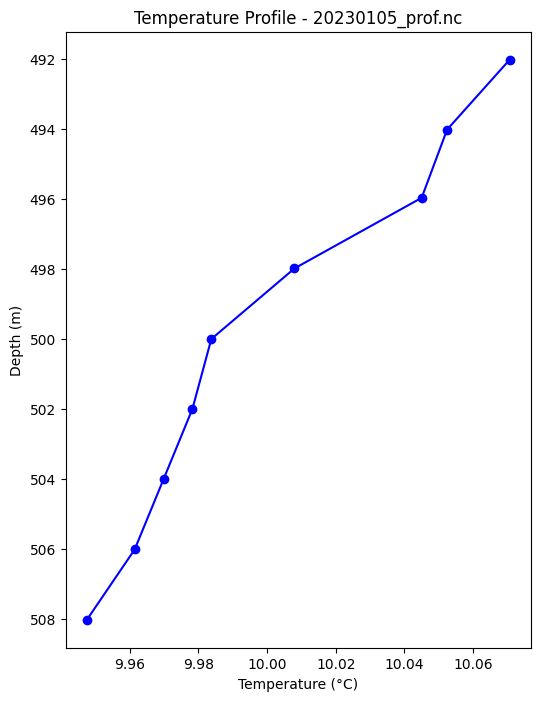

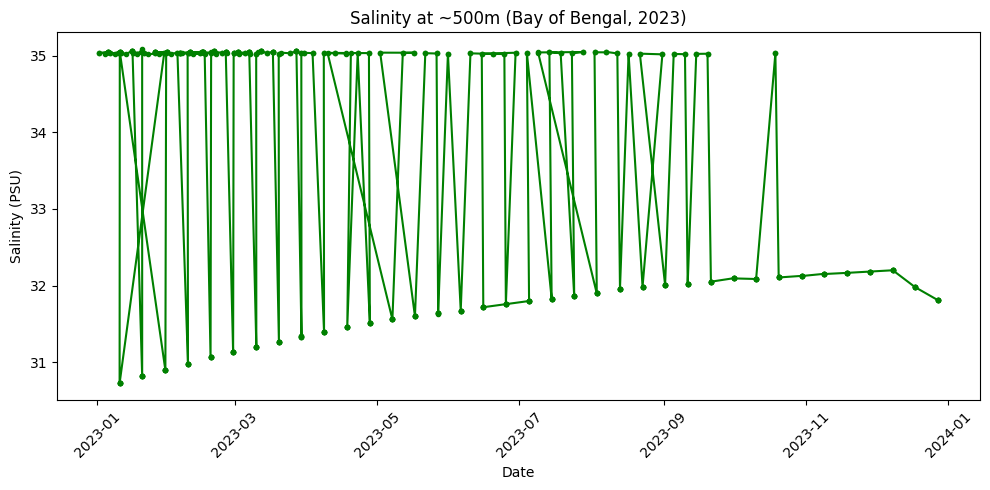

In [3]:
import matplotlib.pyplot as plt
import plotly.express as px

# ✅ Depth Profile (Temperature vs Depth)
sample_file = result["source_file"].iloc[0]
profile = result[result["source_file"] == sample_file]

plt.figure(figsize=(6, 8))
plt.plot(profile["TEMP"], profile["DEPTH_M"], marker="o", color="blue")
plt.gca().invert_yaxis()
plt.xlabel("Temperature (°C)")
plt.ylabel("Depth (m)")
plt.title(f"Temperature Profile - {sample_file}")
plt.show()

# ✅ Time Series (Salinity at 500m in Bay of Bengal)
time_series = result[result["DEPTH_M"].between(495, 505)]

plt.figure(figsize=(10, 5))
plt.plot(time_series["JULD"], time_series["PSAL"], marker=".", linestyle="-", color="green")
plt.xlabel("Date")
plt.ylabel("Salinity (PSU)")
plt.title("Salinity at ~500m (Bay of Bengal, 2023)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ✅ Spatial Map (Lat/Lon colored by Temperature)
map_df = result.copy()

fig = px.scatter_geo(
    map_df,
    lat="LATITUDE",
    lon="LONGITUDE",
    color="TEMP",
    title="Spatial Distribution of Temperature (500m depth, 2023)",
    color_continuous_scale="Viridis",
    projection="natural earth"
)
fig.show()


In [4]:
import pandas as pd
import dask.dataframe as dd

# Load metadata catalog
meta_df = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/SIH2025/Data/argo_metadata_catalog.csv")

# Example: Bay of Bengal at ~500m in 2023
lat_min, lat_max = 5, 20
lon_min, lon_max = 80, 95
depth_min, depth_max = 490, 510
year = 2023

# Step 1: Use metadata to find relevant files
candidate_files = meta_df[
    (meta_df["year"] == year) &
    (meta_df["lat_min"] <= lat_max) & (meta_df["lat_max"] >= lat_min) &
    (meta_df["lon_min"] <= lon_max) & (meta_df["lon_max"] >= lon_min) &
    (meta_df["depth_min"] <= depth_max) & (meta_df["depth_max"] >= depth_min)
]["file_path"].tolist()

print(f"Found {len(candidate_files)} candidate parquet files.")

# Step 2: Load only those files with Dask
if candidate_files:
    df = dd.read_parquet(candidate_files)

    subset = df[
        (df.LATITUDE.between(lat_min, lat_max)) &
        (df.LONGITUDE.between(lon_min, lon_max)) &
        (df.DEPTH_M.between(depth_min, depth_max)) &
        (df.JULD.dt.year == year)
    ]

    result = subset.compute()
    print(result.head())
else:
    print("No matching files found.")


Found 12 candidate parquet files.
       LATITUDE  LONGITUDE                          JULD     DEPTH_M     TEMP  \
37705  6.981966  90.029938 2023-01-05 14:25:45.999996416  492.010010  10.0706   
37706  6.981966  90.029938 2023-01-05 14:25:45.999996416  494.010010  10.0524   
37707  6.981966  90.029938 2023-01-05 14:25:45.999996416  495.959991  10.0450   
37708  6.981966  90.029938 2023-01-05 14:25:45.999996416  497.980011  10.0080   
37709  6.981966  90.029938 2023-01-05 14:25:45.999996416  500.000000   9.9838   

            PSAL       source_file  
37705  35.053902  20230105_prof.nc  
37706  35.052399  20230105_prof.nc  
37707  35.051601  20230105_prof.nc  
37708  35.050400  20230105_prof.nc  
37709  35.049198  20230105_prof.nc  


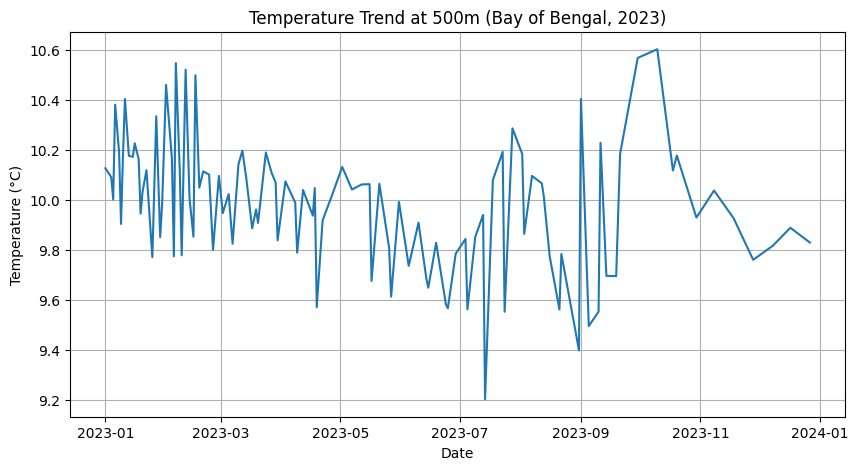

In [5]:
import matplotlib.pyplot as plt

# Group by date, take mean temperature
trend = result.groupby(result["JULD"].dt.date)["TEMP"].mean()

plt.figure(figsize=(10,5))
trend.plot()
plt.title("Temperature Trend at 500m (Bay of Bengal, 2023)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.show()


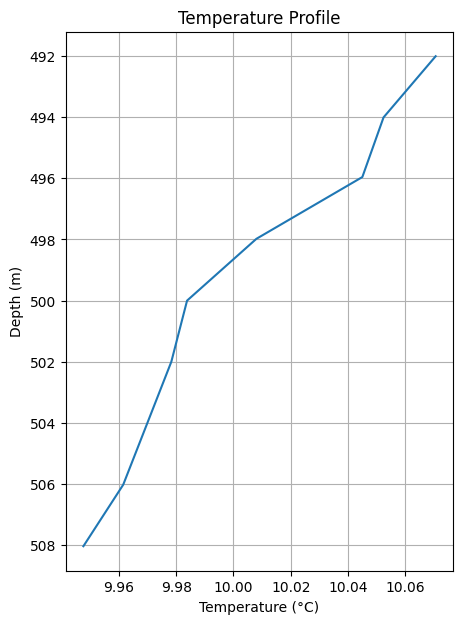

In [6]:
# Pick a single cast/profile
one_profile = result[result["source_file"] == result["source_file"].iloc[0]]

plt.figure(figsize=(5,7))
plt.plot(one_profile["TEMP"], one_profile["DEPTH_M"])
plt.gca().invert_yaxis()
plt.title("Temperature Profile")
plt.xlabel("Temperature (°C)")
plt.ylabel("Depth (m)")
plt.grid(True)
plt.show()


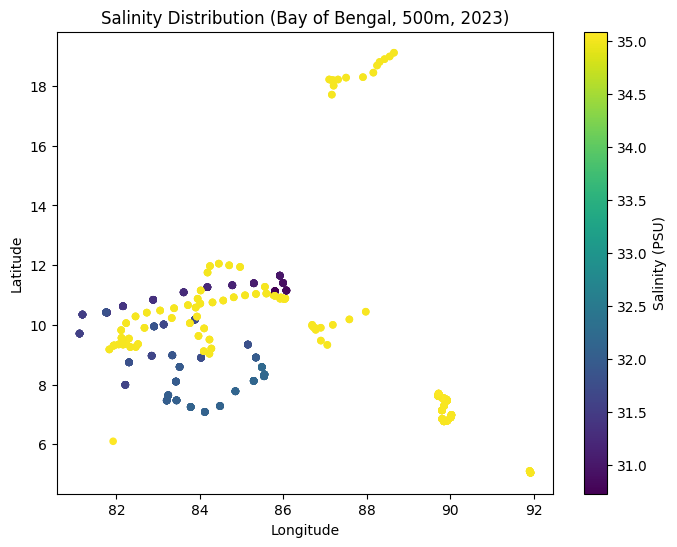

In [7]:
plt.figure(figsize=(8,6))
plt.scatter(result["LONGITUDE"], result["LATITUDE"],
            c=result["PSAL"], cmap="viridis", s=20)
plt.colorbar(label="Salinity (PSU)")
plt.title("Salinity Distribution (Bay of Bengal, 500m, 2023)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


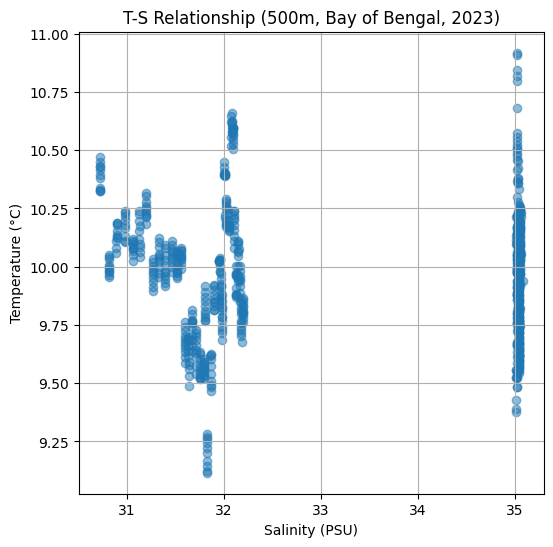

In [8]:
plt.figure(figsize=(6,6))
plt.scatter(result["PSAL"], result["TEMP"], alpha=0.5)
plt.xlabel("Salinity (PSU)")
plt.ylabel("Temperature (°C)")
plt.title("T-S Relationship (500m, Bay of Bengal, 2023)")
plt.grid(True)
plt.show()
